<a href="https://colab.research.google.com/github/MehrdadJalali-AI/SOCIAL-OPTIMIZATION/blob/main/SOCAIL_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

         Function  Best Fitness  Worst Fitness  Mean Fitness       Std Dev  \
0          Sphere    617.561511    1299.658805    908.018296    217.638992   
1   Schwefel 2.22     11.416477      18.559527     15.368410      2.012187   
2    Schwefel 1.2    967.186011    5123.296418   2459.591518   1327.056169   
3   Schwefel 2.21     11.469130      20.362877     15.412602      2.323780   
4      Rosenbrock  14546.003424  144737.980041  64739.370472  46637.615743   
5            Step    577.000000    1893.000000   1120.400000    401.738771   
6         Quartic      0.075180       0.356589      0.167782      0.081117   
7   Schwefel 2.26   6053.372549    9987.930735   8037.116163   1217.645099   
8       Rastrigin     80.810912     159.422890    114.242829     21.553983   
9          Ackley      7.747325      12.224235     10.116089      1.272345   
10       Griewank      6.709070      15.731847     10.328584      2.756991   
11      Penalized      5.181604      11.838580      9.539264    

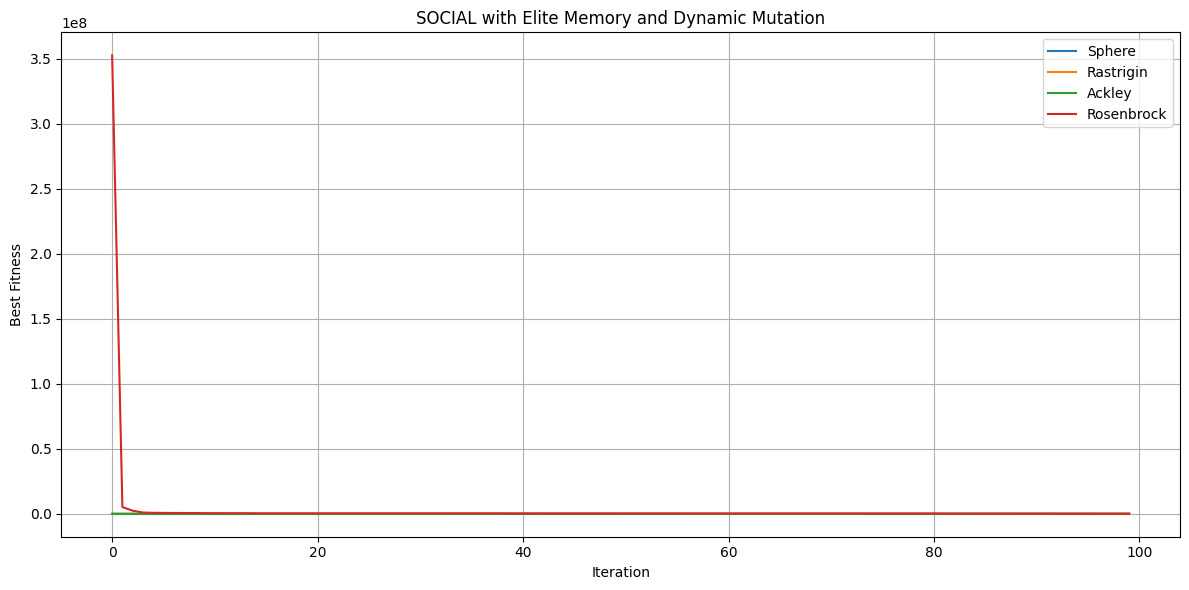

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# --- Benchmark Functions ---
def sphere(x): return sum(xi**2 for xi in x)
def schwefel_2_22(x): return sum(abs(xi) for xi in x) + np.prod([abs(xi) for xi in x])
def schwefel_1_2(x): return sum([sum(x[:i+1])**2 for i in range(len(x))])
def schwefel_2_21(x): return max(abs(xi) for xi in x)
def rosenbrock(x): return sum([100 * (x[i+1] - x[i]**2)**2 + (x[i] - 1)**2 for i in range(len(x)-1)])
def step(x): return sum(np.floor(xi + 0.5)**2 for xi in x)
def quartic(x): return sum((i+1) * xi**4 for i, xi in enumerate(x)) + np.random.uniform(0, 1)
def schwefel_2_26(x): return 418.9829 * len(x) - sum(xi * np.sin(np.sqrt(abs(xi))) for xi in x)
def rastrigin(x): return 10 * len(x) + sum(xi**2 - 10 * np.cos(2 * np.pi * xi) for xi in x)
def ackley(x):
    a, b, c = 20, 0.2, 2 * np.pi
    d = len(x)
    return -a * np.exp(-b * np.sqrt(sum(xi**2 for xi in x) / d)) - np.exp(sum(np.cos(c * xi) for xi in x) / d) + a + np.exp(1)
def griewank(x):
    sum_part = sum(xi**2 / 4000 for xi in x)
    prod_part = np.prod([np.cos(xi / np.sqrt(i + 1)) for i, xi in enumerate(x)])
    return sum_part - prod_part + 1
def penalized(x):
    n = len(x)
    y = [1 + (xi + 1) / 4 for xi in x]
    term1 = 10 * np.sin(np.pi * y[0])**2
    term2 = sum([(y[i] - 1)**2 * (1 + 10 * np.sin(np.pi * y[i+1])**2) for i in range(n-1)])
    term3 = (y[-1] - 1)**2
    u = sum([100 * (xi - 10)**4 if xi > 10 else (-xi - 10)**2 if xi < -10 else 0 for xi in x])
    return (np.pi / n) * (term1 + term2 + term3) + u
def penalized2(x):
    n = len(x)
    term1 = np.sin(3 * np.pi * x[0])**2
    term2 = sum([(x[i] - 1)**2 * (1 + np.sin(3 * np.pi * x[i+1])**2) for i in range(n-1)])
    term3 = (x[-1] - 1)**2 * (1 + np.sin(2 * np.pi * x[-1])**2)
    u = sum([100 * (xi - 10)**4 if xi > 10 else (-xi - 10)**2 if xi < -10 else 0 for xi in x])
    return 0.1 * (term1 + term2 + term3) + u
def alpine(x): return sum(abs(xi * np.sin(xi) + 0.1 * xi) for xi in x)

benchmark_functions = {
    "Sphere": sphere, "Schwefel 2.22": schwefel_2_22, "Schwefel 1.2": schwefel_1_2,
    "Schwefel 2.21": schwefel_2_21, "Rosenbrock": rosenbrock, "Step": step,
    "Quartic": quartic, "Schwefel 2.26": schwefel_2_26, "Rastrigin": rastrigin,
    "Ackley": ackley, "Griewank": griewank, "Penalized": penalized,
    "Penalized2": penalized2, "Alpine": alpine
}

function_details = {
    "Sphere": (30, [-100, 100]), "Schwefel 2.22": (30, [-10, 10]), "Schwefel 1.2": (30, [-100, 100]),
    "Schwefel 2.21": (30, [-100, 100]), "Rosenbrock": (30, [-30, 30]), "Step": (30, [-100, 100]),
    "Quartic": (30, [-1.28, 1.28]), "Schwefel 2.26": (30, [-500, 500]), "Rastrigin": (30, [-5.12, 5.12]),
    "Ackley": (30, [-32, 32]), "Griewank": (30, [-600, 600]), "Penalized": (30, [-50, 50]),
    "Penalized2": (30, [-50, 50]), "Alpine": (30, [-10, 10])
}

# --- Refined SOCIAL Core Functions ---
def initialize_population_social(num_nodes, dim, bounds):
    G = nx.watts_strogatz_graph(num_nodes, k=4, p=0.3)
    for node in G.nodes:
        G.nodes[node]['position'] = np.random.uniform(bounds[0], bounds[1], dim)
        G.nodes[node]['fitness'] = None
    return G

def evaluate_fitness_social(G, func):
    for node in G.nodes:
        pos = G.nodes[node]['position']
        G.nodes[node]['fitness'] = func(pos)
    return len(G.nodes)

def diffuse_information(G, gbest_pos, elite_pos, alpha, beta, gamma, delta, bounds, iteration, max_iterations):
    centrality = nx.betweenness_centrality(G)
    fitness_values = np.array([G.nodes[n]['fitness'] for n in G.nodes])
    max_fitness = max(fitness_values) + 1e-6
    influence = 1 - (fitness_values / max_fitness)

    # Dynamic parameters
    alpha_t = alpha * (1 - iteration / max_iterations)
    beta_t = beta * (1 - iteration / max_iterations)
    gamma_t = gamma * (iteration / max_iterations)
    delta_t = delta * (iteration / max_iterations)  # Elite influence increases over time

    new_positions = {}
    for node in G.nodes:
        neighbors = list(G.neighbors(node))
        if not neighbors:
            new_positions[node] = G.nodes[node]['position']
            continue

        weights = [alpha_t * centrality[n] + beta_t * influence[n] for n in neighbors]
        weights = np.array(weights)
        weights = weights / weights.sum() if weights.sum() > 0 else np.ones_like(weights) / len(weights)
        neighbor_positions = [G.nodes[n]['position'] for n in neighbors]
        neighbor_contribution = np.average(neighbor_positions, weights=weights, axis=0)

        # Combine self, neighbor, gbest, and elite contributions
        new_pos = (
            G.nodes[node]['position'] * (1 - alpha_t - beta_t - gamma_t - delta_t) +
            neighbor_contribution * (alpha_t + beta_t) +
            gbest_pos * gamma_t +
            elite_pos * delta_t
        )
        new_positions[node] = np.clip(new_pos, bounds[0], bounds[1])

    # Dynamic mutation: strength decreases over iterations
    median_fitness = np.median(fitness_values)
    mutation_rate = 0.1  # Fixed probability
    mutation_strength = 0.1 * (1 - iteration / max_iterations) + 0.01  # Decays from 10% to 1%
    mutation_range = mutation_strength * (bounds[1] - bounds[0])
    for node in G.nodes:
        if G.nodes[node]['fitness'] > median_fitness and np.random.random() < mutation_rate:
            perturbation = np.random.uniform(-mutation_range, mutation_range, len(new_positions[node]))
            new_positions[node] = np.clip(new_positions[node] + perturbation, bounds[0], bounds[1])

    for node, pos in new_positions.items():
        G.nodes[node]['position'] = pos

def social_optimize(func, dim, bounds, num_nodes=30, iterations=100, alpha=0.4, beta=0.4, gamma=0.2, delta=0.1):
    G = initialize_population_social(num_nodes, dim, bounds)
    fitness_history = []
    total_evaluations = 0

    # Initialize global best and elite
    evaluate_fitness_social(G, func)
    fitness_values = [G.nodes[n]['fitness'] for n in G.nodes]
    gbest_idx = np.argmin(fitness_values)
    gbest_pos = G.nodes[gbest_idx]['position'].copy()
    gbest_fitness = fitness_values[gbest_idx]
    elite_pos = gbest_pos.copy()  # Elite starts as initial gbest
    elite_fitness = gbest_fitness

    for iteration in range(iterations):
        evaluations = evaluate_fitness_social(G, func)
        total_evaluations += evaluations

        # Update global best and elite
        fitness_values = [G.nodes[n]['fitness'] for n in G.nodes]
        min_fitness_idx = np.argmin(fitness_values)
        if fitness_values[min_fitness_idx] < gbest_fitness:
            gbest_pos = G.nodes[min_fitness_idx]['position'].copy()
            gbest_fitness = fitness_values[min_fitness_idx]
        if gbest_fitness < elite_fitness:  # Update elite if gbest improves
            elite_pos = gbest_pos.copy()
            elite_fitness = gbest_fitness

        diffuse_information(G, gbest_pos, elite_pos, alpha, beta, gamma, delta, bounds, iteration, iterations)
        fitness_history.append(gbest_fitness)

    best_solution = elite_pos  # Return elite as final best
    final_positions = np.array([G.nodes[n]['position'] for n in G.nodes])
    return fitness_history, best_solution, total_evaluations, final_positions

# --- Run on All Functions ---
num_runs = 10
max_iterations = 100
num_nodes = 30

results = []

for name, func in benchmark_functions.items():
    dim, bounds = function_details[name]
    all_histories = []
    all_final_pos = []
    best_fits = []

    for _ in range(num_runs):
        hist, _, _, final_positions = social_optimize(func, dim, bounds, num_nodes, max_iterations)
        all_histories.append(hist)
        best_fits.append(min(hist))
        all_final_pos.append(final_positions)

    mean_fit = np.mean(best_fits)
    std_fit = np.std(best_fits)
    diversity = np.mean([np.var(pos) for pos in all_final_pos])
    robustness = np.var(best_fits)
    convergence_speed = (num_nodes * max_iterations) / max_iterations  # Equal to num_nodes

    results.append({
        "Function": name,
        "Best Fitness": np.min(best_fits),
        "Worst Fitness": np.max(best_fits),
        "Mean Fitness": mean_fit,
        "Std Dev": std_fit,
        "Robustness": robustness,
        "Diversity": diversity,
        "Convergence Speed": convergence_speed
    })

# --- Save CSV ---
df_results = pd.DataFrame(results)
df_results.to_csv("SOCIAL_Results_Elite_Dynamic.csv", index=False)
print(df_results)

# --- Plot convergence for selected functions ---
selected = ["Sphere", "Rastrigin", "Ackley", "Rosenbrock"]
plt.figure(figsize=(12, 6))
for i, name in enumerate(selected):
    dim, bounds = function_details[name]
    hist, _, _, _ = social_optimize(benchmark_functions[name], dim, bounds)
    plt.plot(hist, label=name)
plt.xlabel("Iteration")
plt.ylabel("Best Fitness")
plt.title("SOCIAL with Elite Memory and Dynamic Mutation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Final Best Fitness: 0.000002


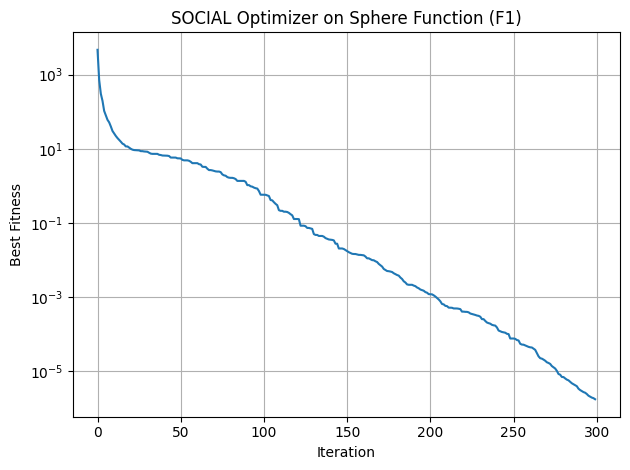

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# --- Sphere Function (F1) ---
def sphere(x): return sum(xi**2 for xi in x)

# --- Initialize Graph and Population ---
def initialize_population(num_nodes, dim, bounds):
    G = nx.watts_strogatz_graph(num_nodes, k=4, p=0.3)
    for node in G.nodes:
        G.nodes[node]['position'] = np.random.uniform(bounds[0], bounds[1], dim)
        G.nodes[node]['fitness'] = None
    return G

# --- Evaluate Fitness ---
def evaluate_fitness(G, func):
    for node in G.nodes:
        pos = G.nodes[node]['position']
        G.nodes[node]['fitness'] = func(pos)

# --- Diffusion with Centrality and Mutation ---
def diffuse(G, gbest_pos, elite_pos, alpha, beta, gamma, delta, bounds, iteration, max_iterations, enable_mutation=True):
    centrality = nx.betweenness_centrality(G)
    fitness_values = np.array([G.nodes[n]['fitness'] for n in G.nodes])
    influence = 1 - (fitness_values / (max(fitness_values) + 1e-6))

    # Dynamic weights (no normalization)
    alpha_t = alpha * (1 - iteration / max_iterations)
    beta_t  = beta  * (1 - iteration / max_iterations)
    gamma_t = gamma * (iteration / max_iterations)
    delta_t = delta * (iteration / max_iterations)

    new_positions = {}
    for node in G.nodes:
        neighbors = list(G.neighbors(node))
        if not neighbors:
            new_positions[node] = G.nodes[node]['position']
            continue

        weights = [alpha_t * centrality[n] + beta_t * influence[i] for i, n in enumerate(neighbors)]
        weights = np.array(weights)
        weights = weights / weights.sum() if weights.sum() > 0 else np.ones_like(weights) / len(weights)
        neighbor_positions = [G.nodes[n]['position'] for n in neighbors]
        neighbor_contribution = np.average(neighbor_positions, weights=weights, axis=0)

        # Updated position using weighted sum
        new_pos = (
            G.nodes[node]['position'] * (1 - alpha_t - beta_t - gamma_t - delta_t) +
            neighbor_contribution * (alpha_t + beta_t) +
            gbest_pos * gamma_t +
            elite_pos * delta_t
        )
        new_positions[node] = np.clip(new_pos, bounds[0], bounds[1])

    # Dynamic mutation (optional)
    if enable_mutation:
        mutation_rate = 0.1
        mutation_strength = 0.1 * (1 - iteration / max_iterations) + 0.01
        mutation_range = mutation_strength * (bounds[1] - bounds[0])
        median_fitness = np.median(fitness_values)

        for node in G.nodes:
            pos = new_positions[node]
            if G.nodes[node]['fitness'] > median_fitness and np.random.rand() < mutation_rate:
                perturb = np.random.uniform(-mutation_range, mutation_range, len(pos))
                pos = np.clip(pos + perturb, bounds[0], bounds[1])
                #print(f"Mutation applied at iteration {iteration} on node {node}")
            G.nodes[node]['position'] = pos
    else:
        for node, pos in new_positions.items():
            G.nodes[node]['position'] = pos

# --- SOCIAL Optimizer (Sphere Only) ---
def social_optimize_sphere(dim=30, bounds=[-30, 30], num_nodes=1000, iterations=300, enable_mutation=True):
    func = sphere
    alpha, beta, gamma, delta = 0.4, 0.4, 0.2, 0.2
    G = initialize_population(num_nodes, dim, bounds)

    evaluate_fitness(G, func)
    fitness_values = [G.nodes[n]['fitness'] for n in G.nodes]
    gbest_idx = np.argmin(fitness_values)
    gbest_pos = G.nodes[gbest_idx]['position'].copy()
    gbest_fitness = fitness_values[gbest_idx]
    elite_pos = gbest_pos.copy()
    elite_fitness = gbest_fitness

    fitness_history = []

    for iteration in range(iterations):
        evaluate_fitness(G, func)
        fitness_values = [G.nodes[n]['fitness'] for n in G.nodes]

        min_idx = np.argmin(fitness_values)
        if fitness_values[min_idx] < gbest_fitness:
            gbest_pos = G.nodes[min_idx]['position'].copy()
            gbest_fitness = fitness_values[min_idx]

        if gbest_fitness < elite_fitness:
            elite_pos = gbest_pos.copy()
            elite_fitness = gbest_fitness

        fitness_history.append(elite_fitness)
        #print(f"Iteration {iteration+1}: Elite Fitness = {elite_fitness:.6f}")

        diffuse(G, gbest_pos, elite_pos, alpha, beta, gamma, delta, bounds, iteration, iterations, enable_mutation)

    return fitness_history, elite_pos, elite_fitness

# --- Run and Plot ---
history, best_pos, best_fit = social_optimize_sphere()
print(f"\nFinal Best Fitness: {best_fit:.6f}")

plt.plot(history)
plt.xlabel("Iteration")
plt.ylabel("Best Fitness")
plt.title("SOCIAL Optimizer on Sphere Function (F1)")
plt.yscale('log')  # Use log scale to show convergence trend clearly
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

# --- Configuration (Hyperparameters) ---
class Config:
    # General parameters
    DIM = 30
    NUM_NODES = 100
    ITERATIONS = 2000
    NUM_RUNS = 100

    # Graph parameters
    K = 4                  # Number of nearest neighbors in Watts-Strogatz graph
    P = 0.3                # Rewiring probability in Watts-Strogatz graph

    # Diffusion weights
    ALPHA = 0.4            # Centrality weight
    BETA = 0.4             # Influence weight
    GAMMA = 0.2            # Global best weight
    DELTA = 0.2            # Elite best weight

    # Mutation parameters
    MUTATION_RATE = 0.1    # Probability of mutation
    MUTATION_STRENGTH_BASE = 0.1  # Initial mutation strength
    MUTATION_STRENGTH_MIN = 0.01  # Minimum mutation strength

# --- Benchmark Functions (F1-F13) ---
def sphere(x): return np.sum(x**2)
def schwefel_2_22(x): return np.sum(np.abs(x)) + np.prod(np.abs(x))
def schwefel_1_2(x): return np.sum([np.sum(x[:i+1])**2 for i in range(len(x))])
def schwefel_2_21(x): return np.max(np.abs(x))
def rosenbrock(x): return np.sum([100 * (x[i+1] - x[i]**2)**2 + (1 - x[i])**2 for i in range(len(x)-1)])
def step(x): return np.sum(np.floor(x + 0.5)**2)
def quartic(x): return np.sum([(i+1) * xi**4 for i, xi in enumerate(x)]) + np.random.uniform(0, 1)
def schwefel_2_26(x): return 418.9829 * len(x) - np.sum(x * np.sin(np.sqrt(np.abs(x))))
def rastrigin(x): return 10 * len(x) + np.sum(x**2 - 10 * np.cos(2 * np.pi * x))
def ackley(x):
    a, b, c = 20, 0.2, 2 * np.pi
    d = len(x)
    return -a * np.exp(-b * np.sqrt(np.sum(x**2) / d)) - np.exp(np.sum(np.cos(c * x)) / d) + a + np.e
def griewank(x): return np.sum(x**2) / 4000 - np.prod(np.cos(x / np.sqrt(np.arange(1, len(x)+1)))) + 1
def penalized(x):
    y = 1 + (x + 1) / 4
    term1 = 10 * np.sin(np.pi * y[0])**2
    term2 = np.sum([(y[i] - 1)**2 * (1 + 10 * np.sin(np.pi * y[i+1])**2) for i in range(len(x)-1)])
    term3 = (y[-1] - 1)**2
    u = np.sum([100 * (xi - 10)**4 if xi > 10 else (-10 - xi)**4 if xi < -10 else 0 for xi in x])
    return (np.pi / len(x)) * (term1 + term2 + term3) + u
def penalized2(x):
    term1 = np.sin(3 * np.pi * x[0])**2
    term2 = np.sum([(x[i] - 1)**2 * (1 + np.sin(3 * np.pi * x[i+1])**2) for i in range(len(x)-1)])
    term3 = (x[-1] - 1)**2 * (1 + np.sin(2 * np.pi * x[-1])**2)
    u = np.sum([0.1 * (xi - 5)**4 if xi > 5 else (-5 - xi)**4 if xi < -5 else 0 for xi in x])
    return 0.1 * (term1 + term2 + term3) + u

# --- Function List and Bounds ---
FUNCTIONS = {
    'Sphere': (sphere, [-100, 100]),
    'Schwefel_2_22': (schwefel_2_22, [-10, 10]),
    'Schwefel_1_2': (schwefel_1_2, [-100, 100]),
    'Schwefel_2_21': (schwefel_2_21, [-100, 100]),
    'Rosenbrock': (rosenbrock, [-30, 30]),
    'Step': (step, [-100, 100]),
    'Quartic': (quartic, [-1.28, 1.28]),
    'Schwefel_2_26': (schwefel_2_26, [-500, 500]),
    'Rastrigin': (rastrigin, [-5.12, 5.12]),
    'Ackley': (ackley, [-32, 32]),
    'Griewank': (griewank, [-600, 600]),
    'Penalized': (penalized, [-50, 50]),
    'Penalized2': (penalized2, [-50, 50])
}

# --- Initialize Graph and Population ---
def initialize_population(num_nodes, dim, bounds):
    G = nx.watts_strogatz_graph(num_nodes, k=Config.K, p=Config.P)
    for node in G.nodes:
        G.nodes[node]['position'] = np.random.uniform(bounds[0], bounds[1], dim)
        G.nodes[node]['fitness'] = None
    return G

# --- Evaluate Fitness ---
def evaluate_fitness(G, func):
    for node in G.nodes:
        pos = G.nodes[node]['position']
        G.nodes[node]['fitness'] = func(pos)

# --- Diffusion with Centrality and Mutation ---
def diffuse(G, gbest_pos, elite_pos, config, bounds, iteration, max_iterations, enable_mutation=True):
    centrality = nx.betweenness_centrality(G)
    fitness_values = np.array([G.nodes[n]['fitness'] for n in G.nodes])
    influence = 1 - (fitness_values / (max(fitness_values) + 1e-6))

    alpha_t = config.ALPHA * (1 - iteration / max_iterations)
    beta_t  = config.BETA  * (1 - iteration / max_iterations)
    gamma_t = config.GAMMA * (iteration / max_iterations)
    delta_t = config.DELTA * (iteration / max_iterations)

    new_positions = {}
    for node in G.nodes:
        neighbors = list(G.neighbors(node))
        if not neighbors:
            new_positions[node] = G.nodes[node]['position']
            continue

        weights = [alpha_t * centrality[n] + beta_t * influence[i] for i, n in enumerate(neighbors)]
        weights = np.array(weights)
        weights = weights / weights.sum() if weights.sum() > 0 else np.ones_like(weights) / len(weights)
        neighbor_positions = [G.nodes[n]['position'] for n in neighbors]
        neighbor_contribution = np.average(neighbor_positions, weights=weights, axis=0)

        new_pos = (
            G.nodes[node]['position'] * (1 - alpha_t - beta_t - gamma_t - delta_t) +
            neighbor_contribution * (alpha_t + beta_t) +
            gbest_pos * gamma_t +
            elite_pos * delta_t
        )
        new_positions[node] = np.clip(new_pos, bounds[0], bounds[1])

    if enable_mutation:
        mutation_strength = config.MUTATION_STRENGTH_BASE * (1 - iteration / max_iterations) + config.MUTATION_STRENGTH_MIN
        mutation_range = mutation_strength * (bounds[1] - bounds[0])
        median_fitness = np.median(fitness_values)

        for node in G.nodes:
            pos = new_positions[node]
            if G.nodes[node]['fitness'] > median_fitness and np.random.rand() < config.MUTATION_RATE:
                perturb = np.random.uniform(-mutation_range, mutation_range, len(pos))
                pos = np.clip(pos + perturb, bounds[0], bounds[1])
            G.nodes[node]['position'] = pos
    else:
        for node, pos in new_positions.items():
            G.nodes[node]['position'] = pos

# --- SOCIAL Optimizer ---
def social_optimize(func_name, config=Config(), enable_mutation=True):
    func, bounds = FUNCTIONS[func_name]
    G = initialize_population(config.NUM_NODES, config.DIM, bounds)

    evaluate_fitness(G, func)
    fitness_values = [G.nodes[n]['fitness'] for n in G.nodes]
    gbest_idx = np.argmin(fitness_values)
    gbest_pos = G.nodes[gbest_idx]['position'].copy()
    gbest_fitness = fitness_values[gbest_idx]
    elite_pos = gbest_pos.copy()
    elite_fitness = gbest_fitness

    fitness_history = []

    for iteration in range(config.ITERATIONS):
        evaluate_fitness(G, func)
        fitness_values = [G.nodes[n]['fitness'] for n in G.nodes]

        min_idx = np.argmin(fitness_values)
        if fitness_values[min_idx] < gbest_fitness:
            gbest_pos = G.nodes[min_idx]['position'].copy()
            gbest_fitness = fitness_values[min_idx]

        if gbest_fitness < elite_fitness:
            elite_pos = gbest_pos.copy()
            elite_fitness = gbest_fitness

        fitness_history.append(elite_fitness)
        diffuse(G, gbest_pos, elite_pos, config, bounds, iteration, config.ITERATIONS, enable_mutation)

    return fitness_history, elite_pos, elite_fitness, G

# --- Run, Compute Metrics, and Save to CSV ---
def run_all_functions(config=Config()):
    results = []

    for name, (func, bounds) in FUNCTIONS.items():
        best_fits = []
        all_histories = []
        final_populations = []

        for _ in range(config.NUM_RUNS):
            history, _, best_fit, G = social_optimize(name, config)
            best_fits.append(best_fit)
            all_histories.append(history)
            final_populations.append(G)

        # Compute metrics
        best_fits = np.array(best_fits)
        mean_fit = np.mean(best_fits)
        std_fit = np.std(best_fits)
        robustness = std_fit**2
        diversity = np.mean([np.mean([np.std([G.nodes[n]['position'][i] for n in G.nodes]) for i in range(config.DIM)]) for G in final_populations])
        convergence_speed = next((i for i, fit in enumerate(all_histories[0]) if fit < mean_fit + std_fit), config.ITERATIONS)

        results.append({
            "Function": name,
            "Best Fitness": np.min(best_fits),
            "Worst Fitness": np.max(best_fits),
            "Mean Fitness": mean_fit,
            "Std Dev": std_fit,
            "Robustness": robustness,
            "Diversity": diversity,
            "Convergence Speed": convergence_speed
        })
        print(f"{name} - Best: {np.min(best_fits):.6f}, Mean: {mean_fit:.6f}, Std Dev: {std_fit:.6f}")

    # Save to CSV
    df = pd.DataFrame(results)
    df.to_csv('social_results.csv', index=False)
    print("\nResults saved to 'social_results.csv'")

    # Plot convergence
    plt.figure(figsize=(12, 8))
    for name in FUNCTIONS.keys():
        history = next(r["Mean Fitness"] for r in results if r["Function"] == name)
        plt.plot(all_histories[0], label=name)  # Using first run's history for plotting
    plt.xlabel("Iteration")
    plt.ylabel("Best Fitness")
    plt.title("SOCIAL Optimizer on Benchmark Functions (F1-F13)")
    plt.yscale('log')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return results

# --- Execute ---
if __name__ == "__main__":
    config = Config()
    results = run_all_functions(config)

Sphere - Best: 0.000000, Mean: 0.000000, Std Dev: 0.000000
Schwefel_2_22 - Best: 0.705217, Mean: 1.223352, Std Dev: 0.526425
Schwefel_1_2 - Best: 0.396531, Mean: 0.615660, Std Dev: 0.198123
Schwefel_2_21 - Best: 1.703657, Mean: 2.913851, Std Dev: 1.254686
Rosenbrock - Best: 26.628561, Mean: 28.141255, Std Dev: 0.753207
Step - Best: 1.000000, Mean: 4.800000, Std Dev: 2.561250
Quartic - Best: 0.000549, Mean: 0.000867, Std Dev: 0.000201
Schwefel_2_26 - Best: 4509.611766, Mean: 5632.378870, Std Dev: 486.456794
Rastrigin - Best: 3.979836, Mean: 12.834968, Std Dev: 8.113030
Ackley - Best: 0.000678, Mean: 2.582869, Std Dev: 1.179304
Griewank - Best: 0.000016, Mean: 0.008708, Std Dev: 0.013250
Penalized - Best: 0.000001, Mean: 0.426664, Std Dev: 0.394891
Penalized2 - Best: 0.000000, Mean: 0.020633, Std Dev: 0.031978

Results saved to 'social_results.csv'


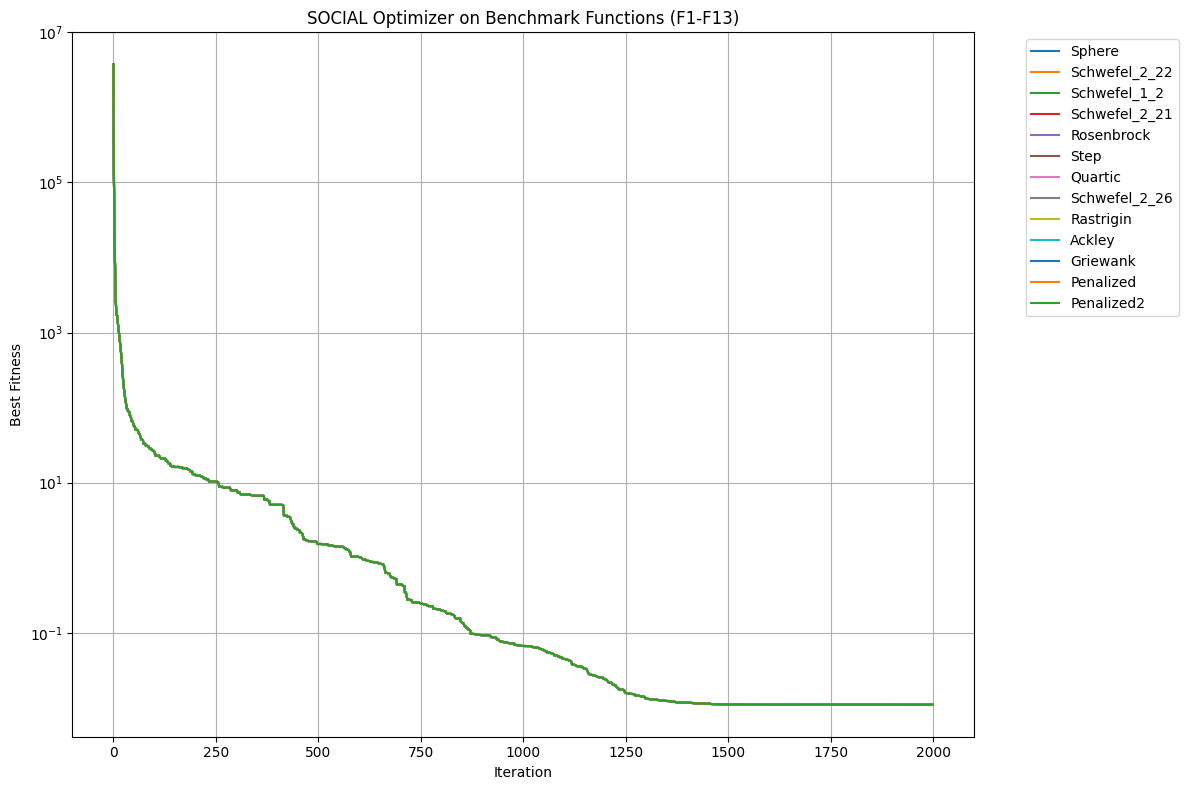

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

# --- Configuration (Hyperparameters) ---
class Config:
    # General parameters
    DIM = 30
    NUM_NODES = 200
    ITERATIONS = 2000
    NUM_RUNS = 10

    # Graph parameters
    K = 3                  # Number of nearest neighbors in Watts-Strogatz graph
    P = 0.1                # Rewiring probability in Watts-Strogatz graph

    # Diffusion weights
    ALPHA = 0.4            # Centrality weight
    BETA = 0.4             # Influence weight
    GAMMA = 0.2            # Global best weight
    DELTA = 0.2            # Elite best weight

    # Mutation parameters
    MUTATION_RATE = 0.1    # Probability of mutation
    MUTATION_STRENGTH_BASE = 0.1  # Initial mutation strength
    MUTATION_STRENGTH_MIN = 0.01  # Minimum mutation strength

# --- Benchmark Functions (F1-F13) ---
def sphere(x): return np.sum(x**2)
def schwefel_2_22(x): return np.sum(np.abs(x)) + np.prod(np.abs(x))
def schwefel_1_2(x): return np.sum([np.sum(x[:i+1])**2 for i in range(len(x))])
def schwefel_2_21(x): return np.max(np.abs(x))
def rosenbrock(x): return np.sum([100 * (x[i+1] - x[i]**2)**2 + (1 - x[i])**2 for i in range(len(x)-1)])
def step(x): return np.sum(np.floor(x + 0.5)**2)
def quartic(x): return np.sum([(i+1) * xi**4 for i, xi in enumerate(x)]) + np.random.uniform(0, 1)
def schwefel_2_26(x): return 418.9829 * len(x) - np.sum(x * np.sin(np.sqrt(np.abs(x))))
def rastrigin(x): return 10 * len(x) + np.sum(x**2 - 10 * np.cos(2 * np.pi * x))
def ackley(x):
    a, b, c = 20, 0.2, 2 * np.pi
    d = len(x)
    return -a * np.exp(-b * np.sqrt(np.sum(x**2) / d)) - np.exp(np.sum(np.cos(c * x)) / d) + a + np.e
def griewank(x): return np.sum(x**2) / 4000 - np.prod(np.cos(x / np.sqrt(np.arange(1, len(x)+1)))) + 1
def penalized(x):
    y = 1 + (x + 1) / 4
    term1 = 10 * np.sin(np.pi * y[0])**2
    term2 = np.sum([(y[i] - 1)**2 * (1 + 10 * np.sin(np.pi * y[i+1])**2) for i in range(len(x)-1)])
    term3 = (y[-1] - 1)**2
    u = np.sum([100 * (xi - 10)**4 if xi > 10 else (-10 - xi)**4 if xi < -10 else 0 for xi in x])
    return (np.pi / len(x)) * (term1 + term2 + term3) + u
def penalized2(x):
    term1 = np.sin(3 * np.pi * x[0])**2
    term2 = np.sum([(x[i] - 1)**2 * (1 + np.sin(3 * np.pi * x[i+1])**2) for i in range(len(x)-1)])
    term3 = (x[-1] - 1)**2 * (1 + np.sin(2 * np.pi * x[-1])**2)
    u = np.sum([0.1 * (xi - 5)**4 if xi > 5 else (-5 - xi)**4 if xi < -5 else 0 for xi in x])
    return 0.1 * (term1 + term2 + term3) + u

# --- Function List and Bounds ---
FUNCTIONS = {
    'Sphere': (sphere, [-100, 100]),
    'Schwefel_2_22': (schwefel_2_22, [-10, 10]),
    'Schwefel_1_2': (schwefel_1_2, [-100, 100]),
    'Schwefel_2_21': (schwefel_2_21, [-100, 100]),
    'Rosenbrock': (rosenbrock, [-30, 30]),
    'Step': (step, [-100, 100]),
    'Quartic': (quartic, [-1.28, 1.28]),
    'Schwefel_2_26': (schwefel_2_26, [-500, 500]),
    'Rastrigin': (rastrigin, [-5.12, 5.12]),
    'Ackley': (ackley, [-32, 32]),
    'Griewank': (griewank, [-600, 600]),
    'Penalized': (penalized, [-50, 50]),
    'Penalized2': (penalized2, [-50, 50])
}

# --- Initialize Graph and Population ---
def initialize_population(num_nodes, dim, bounds):
    G = nx.watts_strogatz_graph(num_nodes, k=Config.K, p=Config.P)
    for node in G.nodes:
        G.nodes[node]['position'] = np.random.uniform(bounds[0], bounds[1], dim)
        G.nodes[node]['fitness'] = None
    return G

# --- Evaluate Fitness ---
def evaluate_fitness(G, func):
    for node in G.nodes:
        pos = G.nodes[node]['position']
        G.nodes[node]['fitness'] = func(pos)

# --- Diffusion with Centrality and Mutation ---
def diffuse(G, gbest_pos, elite_pos, config, bounds, iteration, max_iterations, enable_mutation=True):

    centrality = nx.betweenness_centrality(G, k=10, seed=42)  # Fast approximation

    fitness_values = np.array([G.nodes[n]['fitness'] for n in G.nodes])
    influence = 1 - (fitness_values / (max(fitness_values) + 1e-6))

    alpha_t = config.ALPHA * (1 - iteration / max_iterations)
    beta_t  = config.BETA  * (1 - iteration / max_iterations)
    gamma_t = config.GAMMA * (iteration / max_iterations)
    delta_t = config.DELTA * (iteration / max_iterations)

    new_positions = {}
    for node in G.nodes:
        neighbors = list(G.neighbors(node))
        if not neighbors:
            new_positions[node] = G.nodes[node]['position']
            continue

        weights = [alpha_t * centrality[n] + beta_t * influence[i] for i, n in enumerate(neighbors)]
        weights = np.array(weights)
        weights = weights / weights.sum() if weights.sum() > 0 else np.ones_like(weights) / len(weights)
        neighbor_positions = [G.nodes[n]['position'] for n in neighbors]
        neighbor_contribution = np.average(neighbor_positions, weights=weights, axis=0)

        new_pos = (
            G.nodes[node]['position'] * (1 - alpha_t - beta_t - gamma_t - delta_t) +
            neighbor_contribution * (alpha_t + beta_t) +
            gbest_pos * gamma_t +
            elite_pos * delta_t
        )
        new_positions[node] = np.clip(new_pos, bounds[0], bounds[1])

    if enable_mutation:
        mutation_strength = config.MUTATION_STRENGTH_BASE * (1 - iteration / max_iterations) + config.MUTATION_STRENGTH_MIN
        mutation_range = mutation_strength * (bounds[1] - bounds[0])
        median_fitness = np.median(fitness_values)

        for node in G.nodes:
            pos = new_positions[node]
            if G.nodes[node]['fitness'] > median_fitness and np.random.rand() < config.MUTATION_RATE:
                perturb = np.random.uniform(-mutation_range, mutation_range, len(pos))
                pos = np.clip(pos + perturb, bounds[0], bounds[1])
            G.nodes[node]['position'] = pos
    else:
        for node, pos in new_positions.items():
            G.nodes[node]['position'] = pos

# --- SOCIAL Optimizer ---
def social_optimize(func_name, config=Config(), enable_mutation=True):
    func, bounds = FUNCTIONS[func_name]
    G = initialize_population(config.NUM_NODES, config.DIM, bounds)

    evaluate_fitness(G, func)
    fitness_values = [G.nodes[n]['fitness'] for n in G.nodes]
    gbest_idx = np.argmin(fitness_values)
    gbest_pos = G.nodes[gbest_idx]['position'].copy()
    gbest_fitness = fitness_values[gbest_idx]
    elite_pos = gbest_pos.copy()
    elite_fitness = gbest_fitness

    fitness_history = []

    for iteration in range(config.ITERATIONS):
        evaluate_fitness(G, func)
        fitness_values = [G.nodes[n]['fitness'] for n in G.nodes]

        min_idx = np.argmin(fitness_values)
        if fitness_values[min_idx] < gbest_fitness:
            gbest_pos = G.nodes[min_idx]['position'].copy()
            gbest_fitness = fitness_values[min_idx]

        if gbest_fitness < elite_fitness:
            elite_pos = gbest_pos.copy()
            elite_fitness = gbest_fitness

        fitness_history.append(elite_fitness)
        diffuse(G, gbest_pos, elite_pos, config, bounds, iteration, config.ITERATIONS, enable_mutation)

    return fitness_history, elite_pos, elite_fitness, G

# --- Run, Compute Metrics, and Save to CSV ---
def run_all_functions(config=Config()):
    results = []

    for name, (func, bounds) in FUNCTIONS.items():
        best_fits = []
        all_histories = []
        final_populations = []

        for _ in range(config.NUM_RUNS):
            history, _, best_fit, G = social_optimize(name, config)
            best_fits.append(best_fit)
            all_histories.append(history)
            final_populations.append(G)

        # Compute metrics
        best_fits = np.array(best_fits)
        mean_fit = np.mean(best_fits)
        std_fit = np.std(best_fits)
        robustness = std_fit**2
        diversity = np.mean([np.mean([np.std([G.nodes[n]['position'][i] for n in G.nodes]) for i in range(config.DIM)]) for G in final_populations])
        convergence_speed = next((i for i, fit in enumerate(all_histories[0]) if fit < mean_fit + std_fit), config.ITERATIONS)

        results.append({
            "Function": name,
            "Best Fitness": np.min(best_fits),
            "Worst Fitness": np.max(best_fits),
            "Mean Fitness": mean_fit,
            "Std Dev": std_fit,
            "Robustness": robustness,
            "Diversity": diversity,
            "Convergence Speed": convergence_speed
        })
        print(f"{name} - Best: {np.min(best_fits):.6f}, Mean: {mean_fit:.6f}, Std Dev: {std_fit:.6f}")

    # Save to CSV
    df = pd.DataFrame(results)
    df.to_csv('social_results.csv', index=False)
    print("\nResults saved to 'social_results.csv'")

    # Plot convergence
    plt.figure(figsize=(12, 8))
    for name in FUNCTIONS.keys():
        history = next(r["Mean Fitness"] for r in results if r["Function"] == name)
        plt.plot(all_histories[0], label=name)  # Using first run's history for plotting
    plt.xlabel("Iteration")
    plt.ylabel("Best Fitness")
    plt.title("SOCIAL Optimizer on Benchmark Functions (F1-F13)")
    plt.yscale('log')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return results

# --- Execute ---
if __name__ == "__main__":
    config = Config()
    results = run_all_functions(config)

Sphere - Best: 0.000575, Mean: 0.000876, SR: 0.00
Schwefel_2_22 - Best: 0.052995, Mean: 0.541237, SR: 0.00
Schwefel_1_2 - Best: 0.085376, Mean: 0.248603, SR: 0.00
Schwefel_2_21 - Best: 1.204860, Mean: 1.883393, SR: 0.00
Rosenbrock - Best: 23.479529, Mean: 32.701505, SR: 0.00
Step - Best: 0.000000, Mean: 2.300000, SR: 0.10
Quartic - Best: 0.000497, Mean: 0.000993, SR: 0.00
Schwefel_2_26 - Best: 4698.369141, Mean: 5799.021802, SR: 0.00
Rastrigin - Best: 0.000734, Mean: 2.786772, SR: 0.00
Ackley - Best: 0.008344, Mean: 2.464715, SR: 0.00
Griewank - Best: 0.003357, Mean: 0.017638, SR: 0.00
Penalized - Best: 0.000003, Mean: 0.182407, SR: 0.00
Penalized2 - Best: 0.000029, Mean: 0.005451, SR: 0.00

Results saved to 'social_results.csv'


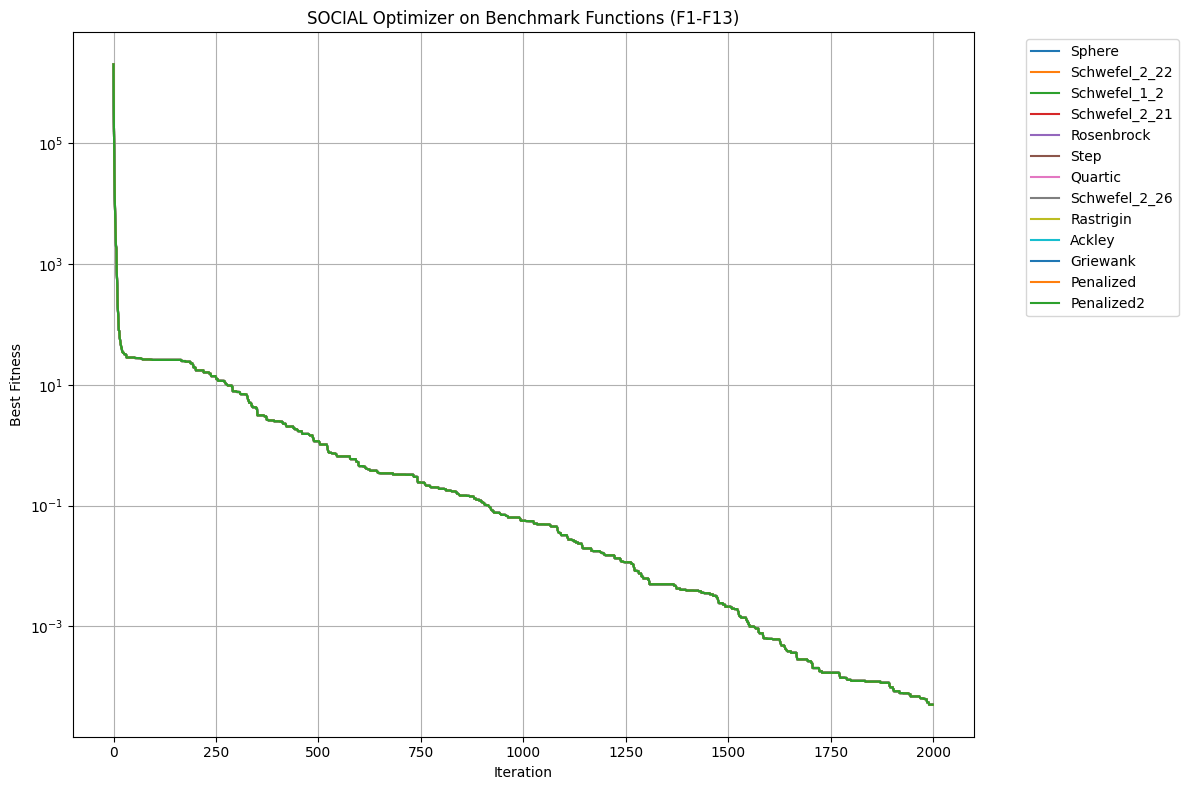

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

# --- Configuration (Hyperparameters) ---
class Config:
    DIM = 30
    NUM_NODES = 200
    ITERATIONS = 2000  # Increased for better convergence
    NUM_RUNS = 10
    K = 3
    P = 0.1
    ALPHA = 0.4
    BETA = 0.4
    GAMMA = 0.2
    DELTA = 0.2
    MUTATION_RATE = 0.1
    MUTATION_STRENGTH_BASE = 0.1
    MUTATION_STRENGTH_MIN = 0.01
    SYNC_WEIGHT = 0.05
    SUCCESS_THRESHOLD = 1e-8

# --- Benchmark Functions with Optima ---
FUNCTIONS = {
    'Sphere': (lambda x: np.sum(x**2), [-100, 100], 0.0),
    'Schwefel_2_22': (lambda x: np.sum(np.abs(x)) + np.prod(np.abs(x)), [-10, 10], 0.0),
    'Schwefel_1_2': (lambda x: np.sum([np.sum(x[:i+1])**2 for i in range(len(x))]), [-100, 100], 0.0),
    'Schwefel_2_21': (lambda x: np.max(np.abs(x)), [-100, 100], 0.0),
    'Rosenbrock': (lambda x: np.sum([100 * (x[i+1] - x[i]**2)**2 + (1 - x[i])**2 for i in range(len(x)-1)]), [-30, 30], 0.0),
    'Step': (lambda x: np.sum(np.floor(x + 0.5)**2), [-100, 100], 0.0),
    'Quartic': (lambda x: np.sum([(i+1) * xi**4 for i, xi in enumerate(x)]) + np.random.uniform(0, 1), [-1.28, 1.28], 0.0),
    'Schwefel_2_26': (lambda x: 418.9829 * len(x) - np.sum(x * np.sin(np.sqrt(np.abs(x)))), [-500, 500], 0.0),
    'Rastrigin': (lambda x: 10 * len(x) + np.sum(x**2 - 10 * np.cos(2 * np.pi * x)), [-5.12, 5.12], 0.0),
    'Ackley': (lambda x: -20 * np.exp(-0.2 * np.sqrt(np.sum(x**2) / len(x))) - np.exp(np.sum(np.cos(2 * np.pi * x)) / len(x)) + 20 + np.e, [-32, 32], 0.0),
    'Griewank': (lambda x: np.sum(x**2) / 4000 - np.prod(np.cos(x / np.sqrt(np.arange(1, len(x)+1)))) + 1, [-600, 600], 0.0),
    'Penalized': (lambda x: (np.pi / len(x)) * (10 * np.sin(np.pi * (1 + (x[0] + 1) / 4))**2 +
                            np.sum([((1 + (x[i] + 1) / 4) - 1)**2 * (1 + 10 * np.sin(np.pi * (1 + (x[i+1] + 1) / 4))**2) for i in range(len(x)-1)]) +
                            ((1 + (x[-1] + 1) / 4) - 1)**2) +
                            np.sum([100 * (xi - 10)**4 if xi > 10 else (-10 - xi)**4 if xi < -10 else 0 for xi in x]), [-50, 50], 0.0),
    'Penalized2': (lambda x: 0.1 * (np.sin(3 * np.pi * x[0])**2 +
                            np.sum([(x[i] - 1)**2 * (1 + np.sin(3 * np.pi * x[i+1])**2) for i in range(len(x)-1)]) +
                            (x[-1] - 1)**2 * (1 + np.sin(2 * np.pi * x[-1])**2)) +
                            np.sum([0.1 * (xi - 5)**4 if xi > 5 else (-5 - xi)**4 if xi < -5 else 0 for xi in x]), [-50, 50], 0.0)
}

# --- Initialize Graph and Population ---
def initialize_population(num_nodes, dim, bounds):
    G = nx.watts_strogatz_graph(num_nodes, k=Config.K, p=Config.P)
    for node in G.nodes:
        G.nodes[node]['position'] = np.random.uniform(bounds[0], bounds[1], dim)
        G.nodes[node]['fitness'] = None
    return G

# --- Evaluate Fitness ---
def evaluate_fitness(G, func):
    for node in G.nodes:
        pos = G.nodes[node]['position']
        G.nodes[node]['fitness'] = func(pos)

# --- Diffusion with Schwefel Adaptations ---
def diffuse(G, gbest_pos, elite_pos, config, bounds, iteration, max_iterations, enable_mutation=True):
    centrality = nx.betweenness_centrality(G, k=10, seed=42)
    fitness_values = np.array([G.nodes[n]['fitness'] for n in G.nodes])
    # Adjusted logarithmic influence for Schwefel
    log_influence = np.log1p(np.abs(fitness_values) + 1e-6)
    influence = 1 - (log_influence / (np.max(log_influence) + 1e-6))

    alpha_t = config.ALPHA * (1 - iteration / max_iterations)
    beta_t = config.BETA * (1 - iteration / max_iterations)
    gamma_t = config.GAMMA * (iteration / max_iterations)
    delta_t = config.DELTA * (iteration / max_iterations)

    dimension_mean = np.mean([G.nodes[n]['position'] for n in G.nodes], axis=0)
    new_positions = {}

    for node in G.nodes:
        neighbors = list(G.neighbors(node))
        if not neighbors:
            new_positions[node] = G.nodes[node]['position']
            continue

        weights = [alpha_t * centrality[n] + beta_t * influence[i] for i, n in enumerate(neighbors)]
        weights = np.array(weights)
        weights = weights / weights.sum() if weights.sum() > 0 else np.ones_like(weights) / len(weights)
        neighbor_positions = [G.nodes[n]['position'] for n in neighbors]
        neighbor_contribution = np.average(neighbor_positions, weights=weights, axis=0)

        new_pos = (
            G.nodes[node]['position'] * (1 - alpha_t - beta_t - gamma_t - delta_t) +
            neighbor_contribution * (alpha_t + beta_t) +
            gbest_pos * gamma_t +
            elite_pos * delta_t
        )
        new_pos = new_pos * (1 - config.SYNC_WEIGHT) + dimension_mean * config.SYNC_WEIGHT
        new_positions[node] = np.clip(new_pos, bounds[0], bounds[1])

    if enable_mutation:
        mutation_strength = config.MUTATION_STRENGTH_BASE * (1 - iteration / max_iterations) + config.MUTATION_STRENGTH_MIN
        mutation_range = mutation_strength * (bounds[1] - bounds[0])
        median_fitness = np.median(fitness_values)

        for node in G.nodes:
            pos = new_positions[node]
            if G.nodes[node]['fitness'] > median_fitness and np.random.rand() < config.MUTATION_RATE:
                perturb = np.random.uniform(-mutation_range, mutation_range, len(pos))
                pos = np.clip(pos + perturb, bounds[0], bounds[1])
            # Adjusted burst mutation frequency
            if iteration % 10 == 0 and np.random.rand() < 0.05:
                pos += np.random.uniform(-1, 1, len(pos)) * 0.5
            G.nodes[node]['position'] = pos
    else:
        for node, pos in new_positions.items():
            G.nodes[node]['position'] = pos

# --- SOCIAL Optimizer ---
def social_optimize(func_name, config=Config(), enable_mutation=True):
    func, bounds, _ = FUNCTIONS[func_name]
    G = initialize_population(config.NUM_NODES, config.DIM, bounds)

    evaluate_fitness(G, func)
    fitness_values = [G.nodes[n]['fitness'] for n in G.nodes]
    gbest_idx = np.argmin(fitness_values)
    gbest_pos = G.nodes[gbest_idx]['position'].copy()
    gbest_fitness = fitness_values[gbest_idx]
    elite_pos = gbest_pos.copy()
    elite_fitness = gbest_fitness

    fitness_history = []

    for iteration in range(config.ITERATIONS):
        evaluate_fitness(G, func)
        fitness_values = [G.nodes[n]['fitness'] for n in G.nodes]

        min_idx = np.argmin(fitness_values)
        if fitness_values[min_idx] < gbest_fitness:
            gbest_pos = G.nodes[min_idx]['position'].copy()
            gbest_fitness = fitness_values[min_idx]

        if gbest_fitness < elite_fitness:
            elite_pos = gbest_pos.copy()
            elite_fitness = gbest_fitness

        fitness_history.append(elite_fitness)
        diffuse(G, gbest_pos, elite_pos, config, bounds, iteration, config.ITERATIONS, enable_mutation)

    return fitness_history, elite_pos, elite_fitness, G

# --- Run, Compute Metrics, and Save to CSV ---
def run_all_functions(config=Config()):
    results = []

    for name, (func, bounds, optimum) in FUNCTIONS.items():
        best_fits = []
        all_histories = []
        final_populations = []

        for _ in range(config.NUM_RUNS):
            history, _, best_fit, G = social_optimize(name, config)
            best_fits.append(best_fit)
            all_histories.append(history)
            final_populations.append(G)

        # Compute metrics
        best_fits = np.array(best_fits)
        mean_fit = np.mean(best_fits)
        std_fit = np.std(best_fits)
        robustness = std_fit**2
        diversity = np.mean([np.mean([np.std([G.nodes[n]['position'][i] for n in G.nodes]) for i in range(config.DIM)]) for G in final_populations])
        convergence_speed = next((i for i, fit in enumerate(all_histories[0]) if fit < mean_fit + std_fit), config.ITERATIONS)
        success_rate = np.mean([1 if abs(bf - optimum) < config.SUCCESS_THRESHOLD else 0 for bf in best_fits])

        results.append({
            "Function": name,
            "Best Fitness": np.min(best_fits),
            "Worst Fitness": np.max(best_fits),
            "Mean Fitness": mean_fit,
            "Std Dev": std_fit,
            "Robustness": robustness,
            "Diversity": diversity,
            "Convergence Speed": convergence_speed,
            "Success Rate (SR)": success_rate
        })
        print(f"{name} - Best: {np.min(best_fits):.6f}, Mean: {mean_fit:.6f}, SR: {success_rate:.2f}")

    # Save to CSV
    df = pd.DataFrame(results)
    df.to_csv('social_results_New2.csv', index=False)
    print("\nResults saved to 'social_results.csv'")

    # Plot convergence
    plt.figure(figsize=(12, 8))
    for name in FUNCTIONS.keys():
        history = next(r["Mean Fitness"] for r in results if r["Function"] == name)
        plt.plot(all_histories[0], label=name)
    plt.xlabel("Iteration")
    plt.ylabel("Best Fitness")
    plt.title("SOCIAL Optimizer on Benchmark Functions (F1-F13)")
    plt.yscale('log')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return results

# --- Execute ---
if __name__ == "__main__":
    config = Config()
    results = run_all_functions(config)

Sphere - Best: 0.000447, Mean: 0.000793, SR: 0.00
Schwefel_2_22 - Best: 0.059622, Mean: 0.458955, SR: 0.00
Schwefel_1_2 - Best: 0.128810, Mean: 0.293429, SR: 0.00
Schwefel_2_21 - Best: 0.393486, Mean: 1.626024, SR: 0.00
Rosenbrock - Best: 23.894095, Mean: 35.752106, SR: 0.00
Step - Best: 1.000000, Mean: 5.400000, SR: 0.00
Quartic - Best: 0.000300, Mean: 0.000997, SR: 0.00
Schwefel_2_26 - Best: 4461.532705, Mean: 5489.638484, SR: 0.00
Rastrigin - Best: 0.001206, Mean: 2.653915, SR: 0.00
Ackley - Best: 1.340660, Mean: 2.483158, SR: 0.00
Griewank - Best: 0.001882, Mean: 0.013783, SR: 0.00
Penalized - Best: 0.000002, Mean: 0.300708, SR: 0.00
Penalized2 - Best: 0.000021, Mean: 0.002245, SR: 0.00
Foxholes - Best: 0.472206, Mean: 0.472206, SR: 0.00
Kowalik - Best: 0.001053, Mean: 0.001144, SR: 0.00
Camel-Back - Best: -1.031628, Mean: -1.031628, SR: 0.00
Branin - Best: 0.397887, Mean: 0.397887, SR: 0.00
Goldstein-Price - Best: -1418921.432211, Mean: -1359940.738169, SR: 0.00
Hartman - Best: -3

<ipython-input-1-b886f64c8591>:315: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


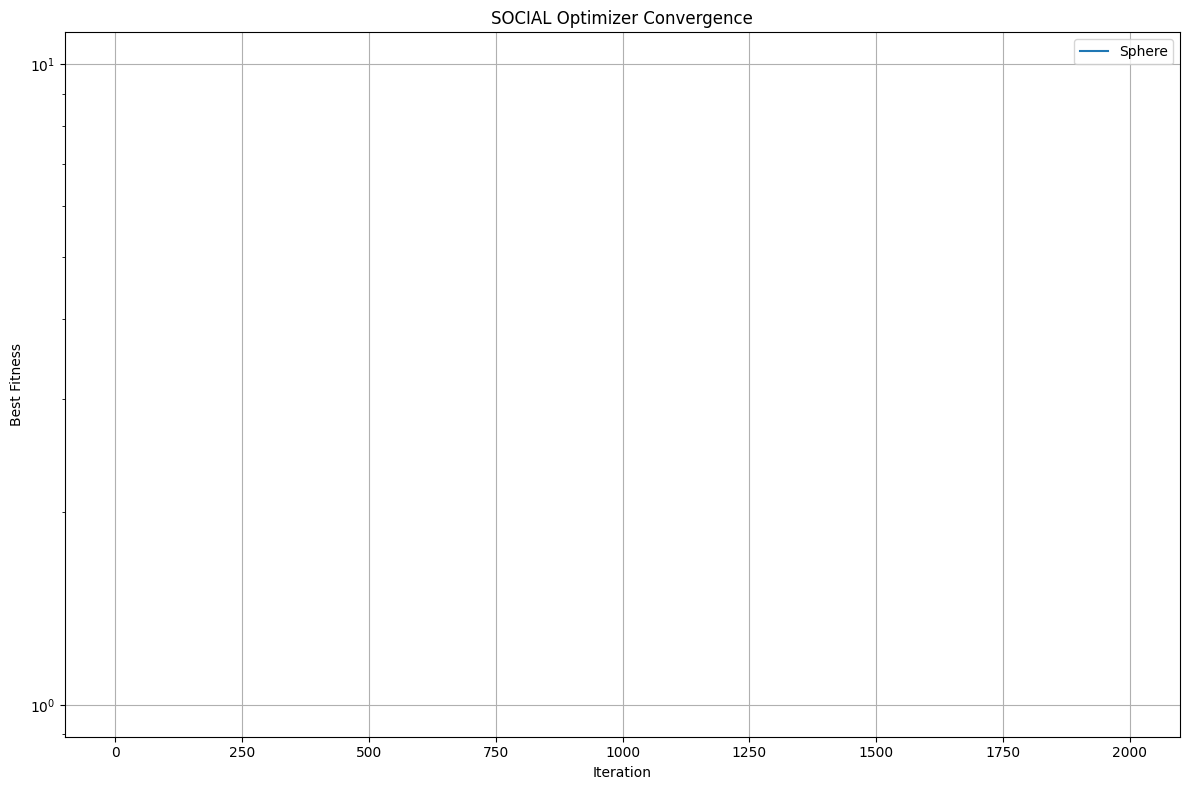

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

# --- Configuration (Hyperparameters) ---
class Config:
    DIM = 30
    NUM_NODES = 200
    ITERATIONS = 2000  # Increased for better convergence
    NUM_RUNS = 15
    K = 3
    P = 0.1
    ALPHA = 0.4
    BETA = 0.4
    GAMMA = 0.2
    DELTA = 0.2
    MUTATION_RATE = 0.1
    MUTATION_STRENGTH_BASE = 0.1
    MUTATION_STRENGTH_MIN = 0.01
    SYNC_WEIGHT = 0.05
    SUCCESS_THRESHOLD = 1e-8

# --- Benchmark Functions with Optima ---
# The first 13 functions (F1-F13)
FUNCTIONS = {
    'Sphere': (lambda x: np.sum(x**2), [-100, 100], 0.0),
    'Schwefel_2_22': (lambda x: np.sum(np.abs(x)) + np.prod(np.abs(x)), [-10, 10], 0.0),
    'Schwefel_1_2': (lambda x: np.sum([np.sum(x[:i+1])**2 for i in range(len(x))]), [-100, 100], 0.0),
    'Schwefel_2_21': (lambda x: np.max(np.abs(x)), [-100, 100], 0.0),
    'Rosenbrock': (lambda x: np.sum([100 * (x[i+1]-x[i]**2)**2 + (1-x[i])**2 for i in range(len(x)-1)]), [-30, 30], 0.0),
    'Step': (lambda x: np.sum(np.floor(x+0.5)**2), [-100, 100], 0.0),
    'Quartic': (lambda x: np.sum([(i+1)*xi**4 for i, xi in enumerate(x)]) + np.random.uniform(0, 1), [-1.28, 1.28], 0.0),
    'Schwefel_2_26': (lambda x: 418.9829*len(x) - np.sum(x * np.sin(np.sqrt(np.abs(x)))), [-500, 500], 0.0),
    'Rastrigin': (lambda x: 10 * len(x) + np.sum(x**2 - 10*np.cos(2*np.pi*x)), [-5.12, 5.12], 0.0),
    'Ackley': (lambda x: -20 * np.exp(-0.2*np.sqrt(np.sum(x**2)/len(x))) - np.exp(np.sum(np.cos(2*np.pi*x))/len(x)) + 20 + np.e, [-32, 32], 0.0),
    'Griewank': (lambda x: np.sum(x**2)/4000 - np.prod(np.cos(x/np.sqrt(np.arange(1, len(x)+1)))) + 1, [-600,600], 0.0),
    'Penalized': (lambda x: (np.pi/len(x))*(10*np.sin(np.pi*(1+(x[0]+1)/4))**2 +
                               np.sum([((1+(x[i]+1)/4)-1)**2 * (1+10*np.sin(np.pi*(1+(x[i+1]+1)/4))**2)
                                       for i in range(len(x)-1)]) +
                               ((1+(x[-1]+1)/4)-1)**2) +
                              np.sum([100*(xi-10)**4 if xi>10 else (-10-xi)**4 if xi < -10 else 0 for xi in x]),
                  [-50,50], 0.0),
    'Penalized2': (lambda x: 0.1*(np.sin(3*np.pi*x[0])**2 +
                                 np.sum([(x[i]-1)**2 * (1+np.sin(3*np.pi*x[i+1])**2)
                                         for i in range(len(x)-1)]) +
                                 (x[-1]-1)**2 * (1+np.sin(2*np.pi*x[-1])**2)) +
                                np.sum([0.1*(xi-5)**4 if xi>5 else (-5-xi)**4 if xi<-5 else 0 for xi in x]),
                   [-50,50], 0.0)
}

# --- Additional 10 functions from Table 2 (F14-F23) ---

def foxholes(x):
    x = x[:2]
    a = np.array([
        [4.0]*25,
        np.linspace(0, 12, 25)
    ])
    denom = 1/500.0
    for j in range(25):
        sum_term = (x[0] - a[0, j])**6 + (x[1] - a[1, j])**6
        denom += 1.0 / (j + 1 + sum_term)
    return 1.0 / denom

def kowalik(x):
    x = x[:4]
    a = np.array([0.1957, 0.1947, 0.1735, 0.1600, 0.0844,
                  0.0627, 0.0456, 0.0342, 0.0323, 0.0235, 0.0246])
    b = np.array([4, 2, 1, 0.5, 0.25,
                  0.125, 0.0625, 0.03125, 0.015625, 0.0078125, 0.00390625])
    s = 0.0
    for i in range(11):
        s += (a[i] - (x[0]*(b[i]**2 + b[i]*x[1]) / (b[i]**2 + b[i]*x[2] + x[3]*x[2])))**2
    return s

def camel_back(x):
    x = x[:2]
    return 4*x[0]**2 - 2.1*x[0]**4 + (1/3)*x[0]**6 + x[0]*x[1] - 4*x[1]**2 + 4*x[1]**4

def branin(x):
    x = x[:2]
    a = 1.0
    b = 5.1 / (4 * np.pi**2)
    c = 5 / np.pi
    r = 6.0
    s = 10.0
    t = 1.0 / (8 * np.pi)
    return (x[1] - b*x[0]**2 + c*x[0] - r)**2 + s*(1-t)*np.cos(x[0]) + s

def goldstein_price(x):
    x = x[:2]
    term1 = 1 + (x[0] + x[1] + 1)**2 * (19 - 14*x[0] + 3*x[1] - 14*x[1] + 6*x[0]*x[1] + 3*x[1]**2)
    term2 = 30 + (2*x[0] - 3*x[1])**2 * (18 - 32*x[0] + 12*x[1] + 48*x[0] - 36*x[0]*x[1] + 27*x[1]**2)
    return term1 * term2

def hartman3(x):
    x = x[:3]
    alpha = np.array([1.0, 1.2, 3.0, 3.2])
    A = np.array([[3.0, 10, 30],
                  [0.1, 10, 35],
                  [3.0, 10, 30],
                  [0.1, 10, 35]])
    P = 1e-4 * np.array([[3689, 1170, 2673],
                         [4699, 4387, 7470],
                         [1091, 8732, 5547],
                         [381, 5743, 8828]])
    outer = 0.0
    for i in range(4):
        inner = np.sum(A[i] * ((x - P[i])**2))
        outer += alpha[i] * np.exp(-inner)
    return -outer

def shekel4(x):
    x = x[:4]
    m = 4
    C = 0.1 * np.ones(m)
    A = np.array([[4.0, 1.0, 8.0, 6.0]] * m)
    sum_val = 0.0
    for i in range(m):
        sum_val += 1.0 / (np.sum((x - A[i])**2) + C[i])
    return -sum_val

def shekel5(x):
    x = x[:4]
    m = 5
    C = 0.1 * np.ones(m)
    A = np.array([[4.0, 1.0, 8.0, 6.0]] * m)
    sum_val = 0.0
    for i in range(m):
        sum_val += 1.0 / (np.sum((x - A[i])**2) + C[i])
    return -sum_val

def shekel7(x):
    x = x[:4]
    m = 7
    C = 0.1 * np.ones(m)
    A = np.array([[4, 4, 4, 4],
                  [1, 1, 1, 1],
                  [8, 8, 8, 8],
                  [6, 6, 6, 6],
                  [3, 7, 3, 7],
                  [2, 9, 2, 9],
                  [5, 5, 3, 3]])
    sum_val = 0.0
    for i in range(m):
        sum_val += 1.0 / (np.sum((x - A[i])**2) + C[i])
    return -sum_val

def shekel10(x):
    x = x[:4]
    m = 10
    C = 0.1 * np.ones(m)
    A = np.tile(np.linspace(1, 10, 4), (m, 1))
    sum_val = 0.0
    for i in range(m):
        sum_val += 1.0 / (np.sum((x - A[i])**2) + C[i])
    return -sum_val

# Add the additional functions to the dictionary.
# Note: For functions defined in dimensions lower than Config.DIM, only the first d components are used.
FUNCTIONS.update({
    'Foxholes': (foxholes, [-65.536, 65.536], 0.998),
    'Kowalik': (kowalik, [-5, 5], 0.0003075),
    'Camel-Back': (camel_back, [-5, 5], -1.0316),
    'Branin': (branin, [-5, 5], 0.398),
    'Goldstein-Price': (goldstein_price, [-2, 2], 3.0),
    'Hartman': (hartman3, [-1, 2], -3.86),
    'Shekel1': (shekel4, [0, 1], -3.32),
    'Shekel2': (shekel5, [0, 1], -10.1532),
    'Shekel3': (shekel7, [0, 1], -10.4028),
    'Shekel4': (shekel10, [0, 1], -10.5363)
})

# --- Initialize Graph and Population ---
def initialize_population(num_nodes, dim, bounds):
    G = nx.watts_strogatz_graph(num_nodes, k=Config.K, p=Config.P)
    for node in G.nodes:
        G.nodes[node]['position'] = np.random.uniform(bounds[0], bounds[1], dim)
        G.nodes[node]['fitness'] = None
    return G

# --- Evaluate Fitness ---
def evaluate_fitness(G, func):
    for node in G.nodes:
        pos = G.nodes[node]['position']
        G.nodes[node]['fitness'] = func(pos)

# --- Diffusion with Schwefel Adaptations ---
def diffuse(G, gbest_pos, elite_pos, config, bounds, iteration, max_iterations, enable_mutation=True):
    centrality = nx.betweenness_centrality(G, k=10, seed=42)
    fitness_values = np.array([G.nodes[n]['fitness'] for n in G.nodes])
    # Adjusted logarithmic influence
    log_influence = np.log1p(np.abs(fitness_values) + 1e-6)
    influence = 1 - (log_influence / (np.max(log_influence) + 1e-6))

    alpha_t = config.ALPHA * (1 - iteration / max_iterations)
    beta_t = config.BETA * (1 - iteration / max_iterations)
    gamma_t = config.GAMMA * (iteration / max_iterations)
    delta_t = config.DELTA * (iteration / max_iterations)

    dimension_mean = np.mean([G.nodes[n]['position'] for n in G.nodes], axis=0)
    new_positions = {}

    for node in G.nodes:
        neighbors = list(G.neighbors(node))
        if not neighbors:
            new_positions[node] = G.nodes[node]['position']
            continue

        weights = [alpha_t * centrality[n] + beta_t * influence[i] for i, n in enumerate(neighbors)]
        weights = np.array(weights)
        weights = weights / weights.sum() if weights.sum() > 0 else np.ones_like(weights) / len(weights)
        neighbor_positions = [G.nodes[n]['position'] for n in neighbors]
        neighbor_contribution = np.average(neighbor_positions, weights=weights, axis=0)

        new_pos = (G.nodes[node]['position'] * (1 - alpha_t - beta_t - gamma_t - delta_t) +
                   neighbor_contribution * (alpha_t + beta_t) +
                   gbest_pos * gamma_t +
                   elite_pos * delta_t)
        new_pos = new_pos * (1 - config.SYNC_WEIGHT) + dimension_mean * config.SYNC_WEIGHT
        new_positions[node] = np.clip(new_pos, bounds[0], bounds[1])

    if enable_mutation:
        mutation_strength = config.MUTATION_STRENGTH_BASE * (1 - iteration / max_iterations) + config.MUTATION_STRENGTH_MIN
        mutation_range = mutation_strength * (bounds[1] - bounds[0])
        median_fitness = np.median(fitness_values)

        for node in G.nodes:
            pos = new_positions[node]
            if G.nodes[node]['fitness'] > median_fitness and np.random.rand() < config.MUTATION_RATE:
                perturb = np.random.uniform(-mutation_range, mutation_range, len(pos))
                pos = np.clip(pos + perturb, bounds[0], bounds[1])
            if iteration % 10 == 0 and np.random.rand() < 0.05:
                pos += np.random.uniform(-1, 1, len(pos)) * 0.5
            G.nodes[node]['position'] = pos
    else:
        for node, pos in new_positions.items():
            G.nodes[node]['position'] = pos

# --- SOCIAL Optimizer ---
def social_optimize(func_name, config=Config(), enable_mutation=True):
    func, bounds, optimum = FUNCTIONS[func_name]
    G = initialize_population(config.NUM_NODES, config.DIM, bounds)

    evaluate_fitness(G, func)
    fitness_values = [G.nodes[n]['fitness'] for n in G.nodes]
    gbest_idx = np.argmin(fitness_values)
    gbest_pos = G.nodes[gbest_idx]['position'].copy()
    gbest_fitness = fitness_values[gbest_idx]
    elite_pos = gbest_pos.copy()
    elite_fitness = gbest_fitness

    fitness_history = []

    for iteration in range(config.ITERATIONS):
        evaluate_fitness(G, func)
        fitness_values = [G.nodes[n]['fitness'] for n in G.nodes]

        min_idx = np.argmin(fitness_values)
        if fitness_values[min_idx] < gbest_fitness:
            gbest_pos = G.nodes[min_idx]['position'].copy()
            gbest_fitness = fitness_values[min_idx]

        if gbest_fitness < elite_fitness:
            elite_pos = gbest_pos.copy()
            elite_fitness = gbest_fitness

        fitness_history.append(elite_fitness)
        diffuse(G, gbest_pos, elite_pos, config, bounds, iteration, config.ITERATIONS, enable_mutation)

    return fitness_history, elite_pos, elite_fitness, G

# --- Run, Compute Metrics, and Save to CSV ---
def run_all_functions(config=Config()):
    results = []
    for name, (func, bounds, optimum) in FUNCTIONS.items():
        best_fits = []
        all_histories = []
        final_populations = []
        for _ in range(config.NUM_RUNS):
            history, _, best_fit, G = social_optimize(name, config)
            best_fits.append(best_fit)
            all_histories.append(history)
            final_populations.append(G)
        best_fits = np.array(best_fits)
        mean_fit = np.mean(best_fits)
        std_fit = np.std(best_fits)
        robustness = std_fit**2
        diversity = np.mean([np.mean([np.std([G.nodes[n]['position'][i] for n in G.nodes])
                                      for i in range(config.DIM)]) for G in final_populations])
        convergence_speed = next((i for i, fit in enumerate(all_histories[0]) if fit < mean_fit + std_fit), config.ITERATIONS)
        success_rate = np.mean([1 if abs(bf - optimum) < config.SUCCESS_THRESHOLD else 0 for bf in best_fits])
        results.append({
            "Function": name,
            "Best Fitness": np.min(best_fits),
            "Worst Fitness": np.max(best_fits),
            "Mean Fitness": mean_fit,
            "Std Dev": std_fit,
            "Robustness": robustness,
            "Diversity": diversity,
            "Convergence Speed": convergence_speed,
            "Success Rate (SR)": success_rate
        })
        print(f"{name} - Best: {np.min(best_fits):.6f}, Mean: {mean_fit:.6f}, SR: {success_rate:.2f}")
    df = pd.DataFrame(results)
    df.to_csv('social_results_New2.csv', index=False)
    print("\nResults saved to 'social_results_New2.csv'")
    plt.figure(figsize=(12, 8))
    # Plot convergence for the first function as an example
    plt.plot(all_histories[0], label=list(FUNCTIONS.keys())[0])
    plt.xlabel("Iteration")
    plt.ylabel("Best Fitness")
    plt.title("SOCIAL Optimizer Convergence")
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return results

# --- Execute ---
if __name__ == "__main__":
    config = Config()
    results = run_all_functions(config)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from scipy.stats import ranksums
import itertools
from datetime import datetime
import os
import json
import pickle

# --- Configuration (Hyperparameters) ---
class Config:
    DIM = 30
    NUM_NODES = 200
    ITERATIONS = 2000  # Increased for better convergence
    NUM_RUNS = 15
    K = 3
    P = 0.1
    ALPHA = 0.4
    BETA = 0.4
    GAMMA = 0.2
    DELTA = 0.2
    MUTATION_RATE = 0.1
    MUTATION_STRENGTH_BASE = 0.1
    MUTATION_STRENGTH_MIN = 0.01
    SYNC_WEIGHT = 0.05
    SUCCESS_THRESHOLD = 1e-8

# --- Benchmark Functions with Optima ---
# The first 13 functions (F1-F13)
FUNCTIONS = {
    'Sphere': (lambda x: np.sum(x**2), [-100, 100], 0.0),
    'Schwefel_2_22': (lambda x: np.sum(np.abs(x)) + np.prod(np.abs(x)), [-10, 10], 0.0),
    'Schwefel_1_2': (lambda x: np.sum([np.sum(x[:i+1])**2 for i in range(len(x))]), [-100, 100], 0.0),
    'Schwefel_2_21': (lambda x: np.max(np.abs(x)), [-100, 100], 0.0),
    'Rosenbrock': (lambda x: np.sum([100 * (x[i+1]-x[i]**2)**2 + (1-x[i])**2 for i in range(len(x)-1)]), [-30, 30], 0.0),
    'Step': (lambda x: np.sum(np.floor(x+0.5)**2), [-100, 100], 0.0),
    'Quartic': (lambda x: np.sum([(i+1)*xi**4 for i, xi in enumerate(x)]) + np.random.uniform(0, 1), [-1.28, 1.28], 0.0),
    'Schwefel_2_26': (lambda x: 418.9829*len(x) - np.sum(x * np.sin(np.sqrt(np.abs(x)))), [-500, 500], 0.0),
    'Rastrigin': (lambda x: 10 * len(x) + np.sum(x**2 - 10*np.cos(2*np.pi*x)), [-5.12, 5.12], 0.0),
    'Ackley': (lambda x: -20 * np.exp(-0.2*np.sqrt(np.sum(x**2)/len(x))) - np.exp(np.sum(np.cos(2*np.pi*x))/len(x)) + 20 + np.e, [-32, 32], 0.0),
    'Griewank': (lambda x: np.sum(x**2)/4000 - np.prod(np.cos(x/np.sqrt(np.arange(1, len(x)+1)))) + 1, [-600,600], 0.0),
    'Penalized': (lambda x: (np.pi/len(x))*(10*np.sin(np.pi*(1+(x[0]+1)/4))**2 +
                               np.sum([((1+(x[i]+1)/4)-1)**2 * (1+10*np.sin(np.pi*(1+(x[i+1]+1)/4))**2)
                                       for i in range(len(x)-1)]) +
                               ((1+(x[-1]+1)/4)-1)**2) +
                              np.sum([100*(xi-10)**4 if xi>10 else (-10-xi)**4 if xi < -10 else 0 for xi in x]),
                  [-50,50], 0.0),
    'Penalized2': (lambda x: 0.1*(np.sin(3*np.pi*x[0])**2 +
                                 np.sum([(x[i]-1)**2 * (1+np.sin(3*np.pi*x[i+1])**2)
                                         for i in range(len(x)-1)]) +
                                 (x[-1]-1)**2 * (1+np.sin(2*np.pi*x[-1])**2)) +
                                np.sum([0.1*(xi-5)**4 if xi>5 else (-5-xi)**4 if xi<-5 else 0 for xi in x]),
                   [-50,50], 0.0)
}

# --- Additional 10 functions from Table (F14-F23) ---
def foxholes(x):
    x = x[:2]
    a = np.array([
        [4.0]*25,
        np.linspace(0, 12, 25)
    ])
    denom = 1/500.0
    for j in range(25):
        sum_term = (x[0] - a[0, j])**6 + (x[1] - a[1, j])**6
        denom += 1.0 / (j + 1 + sum_term)
    return 1.0 / denom

def kowalik(x):
    x = x[:4]
    a = np.array([0.1957, 0.1947, 0.1735, 0.1600, 0.0844,
                  0.0627, 0.0456, 0.0342, 0.0323, 0.0235, 0.0246])
    b = np.array([4, 2, 1, 0.5, 0.25,
                  0.125, 0.0625, 0.03125, 0.015625, 0.0078125, 0.00390625])
    s = 0.0
    for i in range(11):
        s += (a[i] - (x[0]*(b[i]**2 + b[i]*x[1]) / (b[i]**2 + b[i]*x[2] + x[3]*x[2])))**2
    return s

def camel_back(x):
    x = x[:2]
    return 4*x[0]**2 - 2.1*x[0]**4 + (1/3)*x[0]**6 + x[0]*x[1] - 4*x[1]**2 + 4*x[1]**4

def branin(x):
    x = x[:2]
    a = 1.0
    b = 5.1 / (4 * np.pi**2)
    c = 5 / np.pi
    r = 6.0
    s = 10.0
    t = 1.0 / (8 * np.pi)
    return (x[1] - b*x[0]**2 + c*x[0] - r)**2 + s*(1-t)*np.cos(x[0]) + s

def goldstein_price(x):
    x = x[:2]
    term1 = 1 + (x[0] + x[1] + 1)**2 * (19 - 14*x[0] + 3*x[1] - 14*x[1] + 6*x[0]*x[1] + 3*x[1]**2)
    term2 = 30 + (2*x[0] - 3*x[1])**2 * (18 - 32*x[0] + 12*x[1] + 48*x[0] - 36*x[0]*x[1] + 27*x[1]**2)
    return term1 * term2

def hartman3(x):
    x = x[:3]
    alpha = np.array([1.0, 1.2, 3.0, 3.2])
    A = np.array([[3.0, 10, 30],
                  [0.1, 10, 35],
                  [3.0, 10, 30],
                  [0.1, 10, 35]])
    P = 1e-4 * np.array([[3689, 1170, 2673],
                         [4699, 4387, 7470],
                         [1091, 8732, 5547],
                         [381, 5743, 8828]])
    outer = 0.0
    for i in range(4):
        inner = np.sum(A[i] * ((x - P[i])**2))
        outer += alpha[i] * np.exp(-inner)
    return -outer

def hartman6(x):
    x = x[:6]
    alpha = np.array([1.0, 1.2, 3.0, 3.2])
    A = np.array([[10, 3, 17, 3.5, 1.7, 8],
                  [0.05, 10, 17, 0.1, 8, 14],
                  [3, 3.5, 1.7, 10, 17, 8],
                  [17, 8, 0.05, 10, 0.1, 14]])
    P = 1e-4 * np.array([[1312, 1696, 5569, 124, 8283, 5886],
                         [2329, 4135, 8307, 3736, 1004, 9991],
                         [2348, 1451, 3522, 2883, 3047, 6650],
                         [4047, 8828, 8732, 5743, 1091, 381]])
    outer = 0.0
    for i in range(4):
        inner = np.sum(A[i] * ((x - P[i])**2))
        outer += alpha[i] * np.exp(-inner)
    return -outer

def shekel5(x):
    x = x[:4]
    m = 5
    C = 0.1 * np.ones(m)
    A = np.array([[4, 4, 4, 4],
                  [1, 1, 1, 1],
                  [8, 8, 8, 8],
                  [6, 6, 6, 6],
                  [3, 7, 3, 7]])
    sum_val = 0.0
    for i in range(m):
        diff = x - A[i]
        sum_val += 1.0 / (np.sum(diff**2) + C[i])
    return -sum_val

def shekel7(x):
    x = x[:4]
    m = 7
    C = 0.1 * np.ones(m)
    A = np.array([[4, 4, 4, 4],
                  [1, 1, 1, 1],
                  [8, 8, 8, 8],
                  [6, 6, 6, 6],
                  [3, 7, 3, 7],
                  [2, 9, 2, 9],
                  [5, 5, 3, 3]])
    sum_val = 0.0
    for i in range(m):
        diff = x - A[i]
        sum_val += 1.0 / (np.sum(diff**2) + C[i])
    return -sum_val

def shekel10(x):
    x = x[:4]
    m = 10
    C = 0.1 * np.ones(m)
    A = np.array([[4, 4, 4, 4],
                  [1, 1, 1, 1],
                  [8, 8, 8, 8],
                  [6, 6, 6, 6],
                  [3, 7, 3, 7],
                  [2, 9, 2, 9],
                  [5, 5, 3, 3],
                  [8, 1, 8, 1],
                  [6, 2, 6, 2],
                  [7, 3.6, 7, 3.6]])
    sum_val = 0.0
    for i in range(m):
        diff = x - A[i]
        sum_val += 1.0 / (np.sum(diff**2) + C[i])
    return -sum_val

# Update the additional functions in the dictionary
FUNCTIONS.update({
    'Foxholes': (foxholes, [-65.536, 65.536], 0.998),
    'Kowalik': (kowalik, [-5, 5], 0.0003075),
    'Camel-Back': (camel_back, [-5, 5], -1.0316),
    'Branin': (branin, [-5, 5], 0.398),
    'Goldstein-Price': (goldstein_price, [-2, 2], 3.0),
    'Hartman': (hartman3, [0, 1], -3.86),
    'Shekel1': (hartman6, [0, 1], -3.322),
    'Shekel2': (shekel5, [0, 1], -10.1532),
    'Shekel3': (shekel7, [0, 1], -10.4028),
    'Shekel4': (shekel10, [0, 1], -10.5363)
})

# --- Initialize Graph and Population ---
def initialize_population(num_nodes, dim, bounds):
    G = nx.watts_strogatz_graph(num_nodes, k=Config.K, p=Config.P)
    for node in G.nodes:
        G.nodes[node]['position'] = np.random.uniform(bounds[0], bounds[1], dim)
        G.nodes[node]['fitness'] = None
    return G

# --- Evaluate Fitness ---
def evaluate_fitness(G, func):
    for node in G.nodes:
        pos = G.nodes[node]['position']
        G.nodes[node]['fitness'] = func(pos)

# --- Diffusion with Schwefel Adaptations ---
def diffuse(G, gbest_pos, elite_pos, config, bounds, iteration, max_iterations, enable_mutation=True):
    centrality = nx.betweenness_centrality(G, k=10, seed=42)
    fitness_values = np.array([G.nodes[n]['fitness'] for n in G.nodes])
    # Adjusted logarithmic influence
    log_influence = np.log1p(np.abs(fitness_values) + 1e-6)
    influence = 1 - (log_influence / (np.max(log_influence) + 1e-6))

    alpha_t = config.ALPHA * (1 - iteration / max_iterations)
    beta_t = config.BETA * (1 - iteration / max_iterations)
    gamma_t = config.GAMMA * (iteration / max_iterations)
    delta_t = config.DELTA * (iteration / max_iterations)

    dimension_mean = np.mean([G.nodes[n]['position'] for n in G.nodes], axis=0)
    new_positions = {}

    for node in G.nodes:
        neighbors = list(G.neighbors(node))
        if not neighbors:
            new_positions[node] = G.nodes[node]['position']
            continue

        weights = [alpha_t * centrality[n] + beta_t * influence[i] for i, n in enumerate(neighbors)]
        weights = np.array(weights)
        weights = weights / weights.sum() if weights.sum() > 0 else np.ones_like(weights) / len(weights)
        neighbor_positions = [G.nodes[n]['position'] for n in neighbors]
        neighbor_contribution = np.average(neighbor_positions, weights=weights, axis=0)

        new_pos = (G.nodes[node]['position'] * (1 - alpha_t - beta_t - gamma_t - delta_t) +
                   neighbor_contribution * (alpha_t + beta_t) +
                   gbest_pos * gamma_t +
                   elite_pos * delta_t)
        new_pos = new_pos * (1 - config.SYNC_WEIGHT) + dimension_mean * config.SYNC_WEIGHT
        new_positions[node] = np.clip(new_pos, bounds[0], bounds[1])

    if enable_mutation:
        mutation_strength = config.MUTATION_STRENGTH_BASE * (1 - iteration / max_iterations) + config.MUTATION_STRENGTH_MIN
        mutation_range = mutation_strength * (bounds[1] - bounds[0])
        median_fitness = np.median(fitness_values)

        for node in G.nodes:
            pos = new_positions[node]
            if G.nodes[node]['fitness'] > median_fitness and np.random.rand() < config.MUTATION_RATE:
                perturb = np.random.uniform(-mutation_range, mutation_range, len(pos))
                pos = np.clip(pos + perturb, bounds[0], bounds[1])
            if iteration % 10 == 0 and np.random.rand() < 0.05:
                pos += np.random.uniform(-1, 1, len(pos)) * 0.5
            G.nodes[node]['position'] = pos
    else:
        for node, pos in new_positions.items():
            G.nodes[node]['position'] = pos

# --- SOCIAL Optimizer ---
def social_optimize(func_name, config=Config(), enable_mutation=True):
    func, bounds, optimum = FUNCTIONS[func_name]
    G = initialize_population(config.NUM_NODES, config.DIM, bounds)

    evaluate_fitness(G, func)
    fitness_values = [G.nodes[n]['fitness'] for n in G.nodes]
    gbest_idx = np.argmin(fitness_values)
    gbest_pos = G.nodes[gbest_idx]['position'].copy()
    gbest_fitness = fitness_values[gbest_idx]
    elite_pos = gbest_pos.copy()
    elite_fitness = gbest_fitness

    fitness_history = []

    for iteration in range(config.ITERATIONS):
        evaluate_fitness(G, func)
        fitness_values = [G.nodes[n]['fitness'] for n in G.nodes]

        min_idx = np.argmin(fitness_values)
        if fitness_values[min_idx] < gbest_fitness:
            gbest_pos = G.nodes[min_idx]['position'].copy()
            gbest_fitness = fitness_values[min_idx]

        if gbest_fitness < elite_fitness:
            elite_pos = gbest_pos.copy()
            elite_fitness = gbest_fitness

        fitness_history.append(elite_fitness)
        diffuse(G, gbest_pos, elite_pos, config, bounds, iteration, config.ITERATIONS, enable_mutation)

    return fitness_history, elite_pos, elite_fitness, G

# --- Wilcoxon Rank-Sum Test ---
def wilcoxon_test(function_results):
    wilcoxon_results = []
    function_names = list(function_results.keys())
    for func1, func2 in itertools.combinations(function_names, 2):
        fitness1 = function_results[func1]
        fitness2 = function_results[func2]
        stat, p_value = ranksums(fitness1, fitness2)
        wilcoxon_results.append({
            "Function 1": func1,
            "Function 2": func2,
            "Statistic": stat,
            "p-value": p_value,
            "Significant (p<0.05)": p_value < 0.05
        })
    return wilcoxon_results

# --- Run, Compute Metrics, and Save to CSV with Checkpointing ---
def run_all_functions(config=Config()):
    # Create temporary directory
    temp_dir = "temp_results"
    os.makedirs(temp_dir, exist_ok=True)

    # Get current date for final filename
    current_date = datetime.now().strftime("%Y-%m-%d")
    results_filename = f'social_results_{current_date}.csv'
    wilcoxon_filename = f'wilcoxon_results_{current_date}.csv'
    plot_filename = f'convergence_plot_{current_date}.png'

    # Load checkpoint
    checkpoint_file = "checkpoint.json"
    completed_functions = []
    if os.path.exists(checkpoint_file):
        try:
            with open(checkpoint_file, 'r') as f:
                completed_functions = json.load(f)
        except:
            print("Error reading checkpoint file. Starting from scratch.")

    # Load existing function results and fitness values
    results = []
    function_results = {}
    temp_fitness_file = os.path.join(temp_dir, "temp_fitness_values.pkl")
    if os.path.exists(temp_fitness_file):
        try:
            with open(temp_fitness_file, 'rb') as f:
                function_results = pickle.load(f)
        except:
            print("Error reading temporary fitness file. Starting fresh.")

    for name in completed_functions:
        temp_result_file = os.path.join(temp_dir, f"temp_results_{name}.csv")
        if os.path.exists(temp_result_file):
            try:
                temp_df = pd.read_csv(temp_result_file)
                results.append(temp_df.to_dict('records')[0])
            except:
                print(f"Error reading {temp_result_file}. Skipping {name}.")

    # Process remaining functions
    first_history = None
    for name, (func, bounds, optimum) in FUNCTIONS.items():
        if name in completed_functions:
            print(f"Skipping {name} (already completed)")
            continue

        print(f"Processing {name}...")
        best_fits = []
        all_histories = []
        final_populations = []
        for _ in range(config.NUM_RUNS):
            history, _, best_fit, G = social_optimize(name, config)
            best_fits.append(best_fit)
            all_histories.append(history)
            final_populations.append(G)

        # Store fitness values for Wilcoxon test
        function_results[name] = best_fits

        # Compute metrics
        best_fits = np.array(best_fits)
        mean_fit = np.mean(best_fits)
        std_fit = np.std(best_fits)
        robustness = std_fit**2
        diversity = np.mean([np.mean([np.std([G.nodes[n]['position'][i] for n in G.nodes])
                                      for i in range(config.DIM)]) for G in final_populations])
        convergence_speed = next((i for i, fit in enumerate(all_histories[0]) if fit < mean_fit + std_fit), config.ITERATIONS)
        success_rate = np.mean([1 if abs(bf - optimum) < config.SUCCESS_THRESHOLD else 0 for bf in best_fits])

        # Save result for this function
        result = {
            "Function": name,
            "Best Fitness": np.min(best_fits),
            "Worst Fitness": np.max(best_fits),
            "Mean Fitness": mean_fit,
            "Std Dev": std_fit,
            "Robustness": robustness,
            "Diversity": diversity,
            "Conv. Speed": convergence_speed,
            "SR": success_rate
        }
        temp_result_file = os.path.join(temp_dir, f"temp_results_{name}.csv")
        pd.DataFrame([result]).to_csv(temp_result_file, index=False)

        # Update results list
        results.append(result)

        # Save fitness values
        with open(temp_fitness_file, 'wb') as f:
            pickle.dump(function_results, f)

        # Update checkpoint
        completed_functions.append(name)
        with open(checkpoint_file, 'w') as f:
            json.dump(completed_functions, f)

        print(f"{name} - Best: {np.min(best_fits):.6f}, Mean: {mean_fit:.6f}, SR: {success_rate:.2f}")

        # Store first function's history for plotting
        if first_history is None:
            first_history = all_histories[0]

    # Save final results
    df = pd.DataFrame(results)
    df.to_csv(results_filename, index=False)
    print(f"\nResults saved to '{results_filename}'")

    # Perform Wilcoxon test and save results
    wilcoxon_results = wilcoxon_test(function_results)
    wilcoxon_df = pd.DataFrame(wilcoxon_results)
    wilcoxon_df.to_csv(wilcoxon_filename, index=False)
    print(f"Wilcoxon test results saved to '{wilcoxon_filename}'")

    # Print significant pairs
    print("\nSignificant Wilcoxon Test Results (p < 0.05):")
    for result in wilcoxon_results:
        if result["Significant (p<0.05)"]:
            print(f"{result['Function 1']} vs {result['Function 2']}: p-value = {result['p-value']:.6f}")

    # Clean up temporary files
    for name in FUNCTIONS.keys():
        temp_result_file = os.path.join(temp_dir, f"temp_results_{name}.csv")
        if os.path.exists(temp_result_file):
            os.remove(temp_result_file)
    if os.path.exists(temp_fitness_file):
        os.remove(temp_fitness_file)
    if os.path.exists(checkpoint_file):
        os.remove(checkpoint_file)
    if os.path.exists(temp_dir) and not os.listdir(temp_dir):
        os.rmdir(temp_dir)

    # Plot convergence for the first function
    if first_history is not None:
        plt.figure(figsize=(12, 8))
        plt.plot(first_history, label=list(FUNCTIONS.keys())[0])
        plt.xlabel("Iteration")
        plt.ylabel("Best Fitness")
        plt.title("SOCIAL Optimizer Convergence")
        plt.yscale('log')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(plot_filename)
        plt.show()

    return results

# --- Execute ---
if __name__ == "__main__":
    config = Config()
    results = run_all_functions(config)

Processing Sphere...


In [1]:
# Mount drive
from google.colab import drive
import os

drive.mount('/content/drive')
# Change working path
os.chdir('/content/drive/MyDrive/Research/Research_SRH/SOCIAL')

Mounted at /content/drive


In [ ]:
import numpy as np
import networkx as nx
import pandas as pd

# --- Configuration ---
class Config:
    DIM = 200
    NUM_NODES = 300
    ITERATIONS = 2500
    K = 3
    P = 0.1
    ALPHA = 0.4
    BETA = 0.4
    GAMMA = 0.2
    DELTA = 0.2
    MUTATION_RATE = 0.2
    MUTATION_STRENGTH_BASE = 0.5
    MUTATION_STRENGTH_MIN = 0.05
    SYNC_WEIGHT = 0.05

# --- Cantilever Beam Specific Functions ---
def cantilever_objective(x):
    return 0.6224 * sum(x)

def cantilever_constraints(x):
    distances = [100 - 20 * i for i in range(5)]  # [100, 80, 60, 40, 20]
    return [1 - (6 * 1000 * d / (30000 * xi**3)) for d, xi in zip(distances, x)]

# --- Engineering Design Applications ---
APPLICATIONS = {
    'Gear Train': {
        'func': lambda x: ((1/6.931) - (x[0] * x[1]) / (x[2] * x[3]))**2,
        'bounds': [12, 60],  # T_A, T_B, T_C, T_D (integers)
        'dim': 4,
        'var_names': ['T_A', 'T_B', 'T_C', 'T_D'],
        'constraint': lambda x: sum([max(0, 12 - xi) + max(0, xi - 60) for xi in x]) + sum([abs(xi - round(xi)) for xi in x]),  # Enforce integer
        'integer': True  # Flag to enforce integer values
    },
    'Cantilever Beam': {
        'func': cantilever_objective,
        'bounds': [(0.01, 100.0)] * 5,
        'dim': 5,
        'var_names': ['w1', 'w2', 'w3', 'w4', 'w5'],
        'constraint': lambda x: sum([max(0, -c) for c in cantilever_constraints(x)]),
        'integer': False
    },
    'Tension/Compression Spring': {
        'func': lambda x: (x[2] + 2) * x[1] * x[0]**2,
        'bounds': [(0.05, 2), (0.25, 1.3), (2, 15)],
        'dim': 3,
        'var_names': ['d', 'D', 'N'],
        'constraint': lambda x: max(0, 4*x[1]/(x[0]*x[2]) - 1) + max(0, x[0] - 0.75),
        'integer': False
    },
    'Pressure Vessel': {
        'func': lambda x: 0.6224 * x[0] * x[2] * x[3] + 1.7781 * x[1] * x[2]**2 + 3.1661 * x[0]**2 * x[3] + 19.84 * x[0]**2 * x[2],
        'bounds': [(0.0625, 99), (0.0625, 99), (10, 200), (10, 200)],
        'dim': 4,
        'var_names': ['Ts', 'Th', 'R', 'L'],
        'constraint': lambda x: sum([abs(xi % 0.0625) for xi in x[:2]]) + max(0, 0.0625 - x[0]) + max(0, 0.0625 - x[1]),
        'integer': False
    },
    'Welded Beam': {
        'func': lambda x: 1.10471 * x[0]**2 * x[1] + 0.04811 * x[2] * x[3] * (14.0 + x[1]),
        'bounds': [(0.1, 2), (0.1, 10), (0.1, 10), (0.1, 2)],
        'dim': 4,
        'var_names': ['h', 'l', 't', 'b'],
        'constraint': lambda x: max(0, x[0] - x[3]) + max(0, 13600 - (1.10471 * x[0]**2 * x[1] / x[2])),
        'integer': False
    },
    'Speed Reducer': {
        'func': lambda x: 0.7854 * x[0] * x[1]**2 * (3.3333 * x[2]**2 + 14.9334 * x[2] - 43.0934) -
                          1.508 * x[0] * (x[5]**2 + x[6]**2) + 7.4777 * (x[5]**3 + x[6]**3) +
                          0.7854 * (x[3] * x[5]**2 + x[4] * x[6]**2),
        'bounds': [(2.6, 3.6), (0.7, 0.8), (17, 28), (7.3, 8.3), (7.3, 8.3), (2.9, 3.9), (5.0, 5.5)],
        'dim': 7,
        'var_names': ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7'],
        'constraint': lambda x: max(0, 27/(x[0] * x[1]**2 * x[2]) - 1),
        'integer': False
    }
}

# --- Initialize Population ---
def initialize_population(num_nodes, dim, bounds, integer=False):
    G = nx.watts_strogatz_graph(num_nodes, k=Config.K, p=Config.P)
    if isinstance(bounds[0], (list, tuple)):
        for node in G.nodes:
            if integer:
                G.nodes[node]['position'] = np.array([np.random.randint(b[0], b[1] + 1) for b in bounds], dtype=int)
            else:
                G.nodes[node]['position'] = np.array([np.random.uniform(b[0], b[1]) for b in bounds])
            G.nodes[node]['fitness'] = None
    else:
        for node in G.nodes:
            if integer:
                G.nodes[node]['position'] = np.random.randint(bounds[0], bounds[1] + 1, dim, dtype=int)
            else:
                G.nodes[node]['position'] = np.random.uniform(bounds[0], bounds[1], dim)
            G.nodes[node]['fitness'] = None
    return G

# --- Evaluate Fitness with Penalty ---
def evaluate_fitness(G, func, constraint, penalty_factor=1e6):
    for node in G.nodes:
        pos = G.nodes[node]['position']
        obj_value = func(pos)
        penalty = penalty_factor * constraint(pos)
        G.nodes[node]['fitness'] = obj_value + penalty if obj_value >= 0 else 1e10

# --- Diffusion with Integer Enforcement ---
def diffuse(G, gbest_pos, elite_pos, config, bounds, iteration, max_iterations, enable_mutation=True, integer=False):
    centrality = nx.betweenness_centrality(G, k=10, seed=42)
    fitness_values = np.array([G.nodes[n]['fitness'] for n in G.nodes])
    log_influence = np.log1p(np.abs(fitness_values) + 1e-6)
    influence = 1 - (log_influence / (np.max(log_influence) + 1e-6))

    alpha_t = config.ALPHA * (1 - iteration / max_iterations)
    beta_t = config.BETA * (1 - iteration / max_iterations)
    gamma_t = config.GAMMA * (iteration / max_iterations)
    delta_t = config.DELTA * (iteration / max_iterations)

    dimension_mean = np.mean([G.nodes[n]['position'] for n in G.nodes], axis=0)
    new_positions = {}

    for node in G.nodes:
        neighbors = list(G.neighbors(node))
        if not neighbors:
            new_positions[node] = G.nodes[node]['position']
            continue

        weights = [alpha_t * centrality[n] + beta_t * influence[i] for i, n in enumerate(neighbors)]
        weights = np.array(weights)
        weights = weights / weights.sum() if weights.sum() > 0 else np.ones_like(weights) / len(weights)
        neighbor_positions = [G.nodes[n]['position'] for n in neighbors]
        neighbor_contribution = np.average(neighbor_positions, weights=weights, axis=0)

        new_pos = (G.nodes[node]['position'] * (1 - alpha_t - beta_t - gamma_t - delta_t) +
                   neighbor_contribution * (alpha_t + beta_t) +
                   gbest_pos * gamma_t +
                   elite_pos * delta_t)
        new_pos = new_pos * (1 - config.SYNC_WEIGHT) + dimension_mean * config.SYNC_WEIGHT
        if isinstance(bounds[0], (list, tuple)):
            new_pos = np.array([np.clip(new_pos[i], bounds[i][0], bounds[i][1]) for i in range(len(new_pos))])
        else:
            new_pos = np.clip(new_pos, bounds[0], bounds[1])
        if integer:
            new_pos = np.round(new_pos).astype(int)  # Enforce integer values
        new_positions[node] = new_pos

    if enable_mutation:
        mutation_strength = config.MUTATION_STRENGTH_BASE * (1 - iteration / max_iterations) + config.MUTATION_STRENGTH_MIN
        mutation_range = [mutation_strength * (b[1] - b[0]) for b in bounds] if isinstance(bounds[0], (list, tuple)) else mutation_strength * (bounds[1] - bounds[0])
        median_fitness = np.median(fitness_values)

        for node in G.nodes:
            pos = new_positions[node]
            if G.nodes[node]['fitness'] > median_fitness and np.random.rand() < config.MUTATION_RATE:
                if integer:
                    perturb = np.random.randint(-int(mr), int(mr) + 1, len(pos)) if isinstance(bounds[0], (list, tuple)) else np.random.randint(-int(mutation_range), int(mutation_range) + 1, len(pos))
                else:
                    perturb = np.array([np.random.uniform(-mr, mr) for mr in mutation_range]) if isinstance(bounds[0], (list, tuple)) else np.random.uniform(-mutation_range, mutation_range, len(pos))
                pos = pos + perturb
            if iteration % 10 == 0 and np.random.rand() < 0.05:
                if integer:
                    pos += np.random.randint(-1, 2, len(pos))  # Small integer perturbation
                else:
                    pos += np.random.uniform(-1, 1, len(pos)) * 0.5
            if isinstance(bounds[0], (list, tuple)):
                pos = np.array([np.clip(pos[i], bounds[i][0], bounds[i][1]) for i in range(len(pos))])
            else:
                pos = np.clip(pos, bounds[0], bounds[1])
            if integer:
                pos = np.round(pos).astype(int)  # Ensure integer after mutation
            G.nodes[node]['position'] = pos
    else:
        for node, pos in new_positions.items():
            G.nodes[node]['position'] = pos

# --- SOCIAL Optimizer ---
def social_optimize(app_name, config=Config(), enable_mutation=True):
    app = APPLICATIONS[app_name]
    func, bounds, dim, var_names, constraint, integer = app['func'], app['bounds'], app['dim'], app['var_names'], app['constraint'], app['integer']
    config.DIM = dim
    G = initialize_population(config.NUM_NODES, config.DIM, bounds, integer)

    evaluate_fitness(G, func, constraint)
    fitness_values = [G.nodes[n]['fitness'] for n in G.nodes]
    gbest_idx = np.argmin(fitness_values)
    gbest_pos = G.nodes[gbest_idx]['position'].copy()
    gbest_fitness = fitness_values[gbest_idx]
    elite_pos = gbest_pos.copy()
    elite_fitness = gbest_fitness

    for iteration in range(config.ITERATIONS):
        evaluate_fitness(G, func, constraint)
        fitness_values = [G.nodes[n]['fitness'] for n in G.nodes]

        min_idx = np.argmin(fitness_values)
        if fitness_values[min_idx] < gbest_fitness:
            gbest_pos = G.nodes[min_idx]['position'].copy()
            gbest_fitness = fitness_values[min_idx]

        if gbest_fitness < elite_fitness:
            elite_pos = gbest_pos.copy()
            elite_fitness = gbest_fitness

        diffuse(G, gbest_pos, elite_pos, config, bounds, iteration, config.ITERATIONS, enable_mutation, integer)

    return elite_pos, func(elite_pos)

# --- Generate Table Output ---
def generate_tables(config=Config()):
    results = {}
    for app_name, app in APPLICATIONS.items():
        best_pos, best_fitness = social_optimize(app_name, config)
        result = {var: val for var, val in zip(app['var_names'], best_pos)}
        result['f(x)'] = best_fitness
        results[app_name] = result

        print(f"\nTable for {app_name}:")
        print("-" * 50)
        for var, val in result.items():
            if var == 'f(x)':
                print(f"{var:<10} = {val:.12f}")
            else:
                print(f"{var:<10} = {val:.0f}" if app.get('integer', False) else f"{var:<10} = {val:.6f}")
        print("-" * 50)

    df = pd.DataFrame.from_dict(results, orient='index')
    df.to_csv('social_optimal_solutions.csv', index_label='Application')
    print("\nResults saved to 'social_optimal_solutions.csv'")
    return results

# --- Execute ---
if __name__ == "__main__":
    config = Config()
    results = generate_tables(config)


Table for Gear Train:
--------------------------------------------------
T_A        = 26
T_B        = 15
T_C        = 51
T_D        = 53
f(x)       = 0.000000000023
--------------------------------------------------

Table for Cantilever Beam:
--------------------------------------------------
w1         = 2.714570
w2         = 2.534135
w3         = 2.294772
w4         = 2.103669
w5         = 1.627312
f(x)       = 7.017222608083
--------------------------------------------------

Table for Tension/Compression Spring:
--------------------------------------------------
d          = 0.066669
D          = 0.250000
N          = 15.000000
f(x)       = 0.018889991407
--------------------------------------------------

Table for Pressure Vessel:
--------------------------------------------------
Ts         = 0.062500
Th         = 0.062500
R          = 10.000000
L          = 10.000000
f(x)       = 15.901800781250
--------------------------------------------------

Table for Welded Beam:
------

Sphere - Best: 0.000610, Mean: 0.000846, SR: 0.00
Schwefel_2_22 - Best: 0.019489, Mean: 0.350449, SR: 0.00
Schwefel_1_2 - Best: 0.060309, Mean: 0.267124, SR: 0.00
Schwefel_2_21 - Best: 0.624360, Mean: 1.800568, SR: 0.00
Rosenbrock - Best: 25.904748, Mean: 27.979144, SR: 0.00
Step - Best: 2.000000, Mean: 7.066667, SR: 0.00
Quartic - Best: 0.000608, Mean: 0.001032, SR: 0.00
Schwefel_2_26 - Best: 4856.292418, Mean: 5764.903012, SR: 0.00
Rastrigin - Best: 0.000507, Mean: 3.184531, SR: 0.00
Ackley - Best: 1.899952, Mean: 2.565907, SR: 0.00
Griewank - Best: 0.001382, Mean: 0.011932, SR: 0.00
Penalized - Best: 0.000002, Mean: 0.159948, SR: 0.00
Penalized2 - Best: 0.000016, Mean: 0.010931, SR: 0.00
Foxholes - Best: 0.472206, Mean: 0.472206, SR: 0.00
Kowalik - Best: 0.001053, Mean: 0.001170, SR: 0.00
Camel-Back - Best: -1.031628, Mean: -1.031628, SR: 0.00
Branin - Best: 0.397887, Mean: 0.397887, SR: 0.00
Goldstein-Price - Best: -1417913.876534, Mean: -1362668.339843, SR: 0.00